In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
import sys
import os
import pickle
import argparse
import importlib
import torch
import numpy as np
from torch.utils.data import DataLoader


# --------------------------------------------------------------------------- #
# 1.1  กำหนด Paths
# --------------------------------------------------------------------------- #
BASE_DIR   = r"z:\AST-With-TB-Classify"
DATA_DIR   = os.path.join(BASE_DIR, "Data")
PTB_DIR    = os.path.join(DATA_DIR, "Cough_PTB")
NONPTB_DIR = os.path.join(DATA_DIR, "Cough_Non-PTB")
FOLD_ROOT  = os.path.join(BASE_DIR, "json_folds_3runs")
N_RUNS            = 3
HOLDOUT_TEST_SIZE = 0.20
RUN_VAL_SIZE      = 0.15
RANDOM_STATE      = 42

SRC_DIR = os.path.join(BASE_DIR, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import dataloader as ast_dataloader
import models
import traintest as _traintest_module

importlib.reload(_traintest_module)
importlib.reload(ast_dataloader)
importlib.reload(models)

from traintest import train
# --------------------------------------------------------------------------- #
# 1.2  รวบรวม Patient ID และไฟล์เสียง
# --------------------------------------------------------------------------- #
def collect_patients(directory, label_str):
    patients = defaultdict(list)
    for wav_path in sorted(glob.glob(os.path.join(directory, "*.wav"))):
        filename   = os.path.basename(wav_path)
        patient_id = filename.split("_")[0]
        patients[patient_id].append({
            "wav":    wav_path.replace("\\", "/"),
            "labels": label_str
        })
    return patients

ptb_patients    = collect_patients(PTB_DIR,    label_str="1")
nonptb_patients = collect_patients(NONPTB_DIR, label_str="0")

ptb_ids    = sorted(ptb_patients.keys())
nonptb_ids = sorted(nonptb_patients.keys())

print(f"PTB     patients ({len(ptb_ids):2d}): {ptb_ids}")
print(f"Non-PTB patients ({len(nonptb_ids):2d}): {nonptb_ids}")
print(f"Total patients  : {len(ptb_ids) + len(nonptb_ids)}\n")

# --------------------------------------------------------------------------- #
# 1.3  สร้าง Subject-level DataFrame
#       ★ เหมือน build_subject_table_from_df() ใน 2DCNN:
#          groupby subject_id → sort_values("subject_id") → reset_index(drop=True)
# --------------------------------------------------------------------------- #
subject_records = []
for pid in sorted(set(list(ptb_patients.keys()) + list(nonptb_patients.keys()))):
    label = 1 if pid in ptb_patients else 0
    subject_records.append({"subject_id": pid, "subject_label": label})

st = (pd.DataFrame(subject_records)
        .sort_values("subject_id")
        .reset_index(drop=True))

y = st["subject_label"].values
print(f"Subject table (st) shape: {st.shape}")
print(st.to_string())

# --------------------------------------------------------------------------- #
# 1.4  Holdout Split 20%
#       ★ เหมือน 2DCNN: ส่ง DataFrame st เข้า train_test_split โดยตรง
#         จากนั้น reset_index(drop=True) ทั้ง train_subj และ test_subj
# --------------------------------------------------------------------------- #
train_subj, test_subj = train_test_split(
    st,
    test_size    = HOLDOUT_TEST_SIZE,
    stratify     = y,
    random_state = RANDOM_STATE
)
train_subj = train_subj.reset_index(drop=True)   # ★ reset index เหมือน 2DCNN
test_subj  = test_subj.reset_index(drop=True)

holdout_ids = sorted(test_subj["subject_id"].tolist())
pool_ids    = sorted(train_subj["subject_id"].tolist())

print("\n" + "=" * 65)
print("STEP 1A — Holdout Test Split (20% of all Patients)")
print("=" * 65)
print(f"  Holdout Test  : {len(test_subj)} patients "
      f"({test_subj['subject_label'].sum()} PTB + "
      f"{(test_subj['subject_label']==0).sum()} Non-PTB)")
print(f"  Pool (80%)    : {len(train_subj)} patients "
      f"({train_subj['subject_label'].sum()} PTB + "
      f"{(train_subj['subject_label']==0).sum()} Non-PTB)")
print(f"  Holdout IDs   : {holdout_ids}")
print(f"  Pool IDs      : {pool_ids}")

# --------------------------------------------------------------------------- #
# 1.5  Per-Run Splits (3 Runs)
#       ★ เหมือน 2DCNN: ส่ง train_subj DataFrame เข้า train_test_split
#         stratify=train_subj["subject_label"].values, seed=RANDOM_STATE+run_i
#         reset_index(drop=True) ทั้ง tr_subj และ va_subj
# --------------------------------------------------------------------------- #
run_assignments = []
for run_i in range(1, N_RUNS + 1):
    tr_subj, va_subj = train_test_split(
        train_subj,
        test_size    = RUN_VAL_SIZE,
        stratify     = train_subj["subject_label"].values,
        random_state = RANDOM_STATE + run_i   # 43, 44, 45 เหมือน 2DCNN
    )
    tr_subj = tr_subj.reset_index(drop=True)  # ★ reset index เหมือน 2DCNN
    va_subj = va_subj.reset_index(drop=True)

    tr_ids = sorted(tr_subj["subject_id"].tolist())
    va_ids = sorted(va_subj["subject_id"].tolist())
    te_ids = set(test_subj["subject_id"].tolist())

    # Leakage check (เหมือน 2DCNN)
    ok = (set(tr_ids).isdisjoint(set(va_ids)) and
          set(tr_ids).isdisjoint(te_ids) and
          set(va_ids).isdisjoint(te_ids))
    print(f"{'✅' if ok else '❌'} Run {run_i}: train/val/test subjects disjoint")

    run_assignments.append({
        "run":   run_i,
        "train": tr_ids,
        "val":   va_ids,
        "seed":  RANDOM_STATE + run_i,
        "tr_subj_df": tr_subj,
        "va_subj_df": va_subj,
    })

# --------------------------------------------------------------------------- #
# 1.6  Helper Functions
# --------------------------------------------------------------------------- #
def patients_to_records(patient_ids, ptb_dict, nonptb_dict):
    records = []
    for pid in patient_ids:
        if pid in ptb_dict:
            records.extend(ptb_dict[pid])
        elif pid in nonptb_dict:
            records.extend(nonptb_dict[pid])
    return records

def save_json(records, filepath):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(filepath, "w") as f:
        json.dump({"data": records}, f, indent=4)

# --------------------------------------------------------------------------- #
# 1.7  บันทึก Holdout Test JSON
# --------------------------------------------------------------------------- #
holdout_records        = patients_to_records(holdout_ids, ptb_patients, nonptb_patients)
holdout_json_path      = os.path.join(FOLD_ROOT, "holdout_test.json")
save_json(holdout_records, holdout_json_path)
n_holdout_ptb_files    = sum(1 for r in holdout_records if r["labels"] == "1")
n_holdout_nonptb_files = len(holdout_records) - n_holdout_ptb_files
print(f"\n  Holdout Test JSON → {holdout_json_path}")
print(f"  Files: {len(holdout_records)} total  [{n_holdout_ptb_files} PTB / {n_holdout_nonptb_files} Non-PTB]")

# --------------------------------------------------------------------------- #
# 1.8  บันทึก JSON ของแต่ละ Run + แสดงสรุป
# --------------------------------------------------------------------------- #
print(f"\n{'=' * 65}")
print("STEP 1B — 3 Independent Random Splits (on 80% Pool) — 2DCNN Style")
print(f"({'Val size per Run = 15% of Pool | Seeds = 43, 44, 45'})")
print(f"{'=' * 65}")

holdout_set = set(holdout_ids)
for ra in run_assignments:
    run_num = ra["run"]
    run_dir = os.path.join(FOLD_ROOT, f"run_{run_num}")

    train_records = patients_to_records(ra["train"], ptb_patients, nonptb_patients)
    val_records   = patients_to_records(ra["val"],   ptb_patients, nonptb_patients)

    save_json(train_records, os.path.join(run_dir, "train_data.json"))
    save_json(val_records,   os.path.join(run_dir, "val_data.json"))

    n_train_ptb = sum(1 for r in train_records if r["labels"] == "1")
    n_val_ptb   = sum(1 for r in val_records   if r["labels"] == "1")
    pct_train   = len(ra["train"]) / len(pool_ids) * 100
    pct_val     = len(ra["val"])   / len(pool_ids) * 100

    print(f"\n  --- RUN {run_num} (seed={ra['seed']}) ---")
    print(f"  TRAIN : {len(ra['train']):2d} patients ({pct_train:.1f}%) "
          f"[{sum(1 for p in ra['train'] if p in ptb_patients)} PTB + "
          f"{sum(1 for p in ra['train'] if p in nonptb_patients)} Non-PTB] "
          f"→ {len(train_records):3d} files  [{n_train_ptb} PTB / {len(train_records)-n_train_ptb} Non-PTB]")
    print(f"  VAL   : {len(ra['val']):2d} patients ({pct_val:.1f}%)  "
          f"[{sum(1 for p in ra['val'] if p in ptb_patients)} PTB + "
          f"{sum(1 for p in ra['val'] if p in nonptb_patients)} Non-PTB] "
          f"→ {len(val_records):3d} files  [{n_val_ptb} PTB / {len(val_records)-n_val_ptb} Non-PTB]")
    print(f"  IDs   → TRAIN: {ra['train']} | VAL: {ra['val']}")

print(f"\n  TEST  : Shared Holdout — {len(holdout_ids)} patients "
      f"→ {len(holdout_records)} files  "
      f"[{n_holdout_ptb_files} PTB / {n_holdout_nonptb_files} Non-PTB]")
print(f"\n[✓] JSON files saved to: {FOLD_ROOT}")
print("[✓] Data preparation complete (2DCNN-Style Splitting).")


z:\AST-With-TB-Classify\venvast\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
z:\AST-With-TB-Classify\venvast\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


PTB     patients ( 7): ['006', '008', '009', '011', '012', '015', '016']
Non-PTB patients ( 8): ['001', '002', '003', '004', '005', '007', '013', '014']
Total patients  : 15

Subject table (st) shape: (15, 2)
   subject_id  subject_label
0         001              0
1         002              0
2         003              0
3         004              0
4         005              0
5         006              1
6         007              0
7         008              1
8         009              1
9         011              1
10        012              1
11        013              0
12        014              0
13        015              1
14        016              1

STEP 1A — Holdout Test Split (20% of all Patients)
  Holdout Test  : 3 patients (1 PTB + 2 Non-PTB)
  Pool (80%)    : 12 patients (6 PTB + 6 Non-PTB)
  Holdout IDs   : ['004', '013', '016']
  Pool IDs      : ['001', '002', '003', '005', '006', '007', '008', '009', '011', '012', '014', '015']
✅ Run 1: train/val/test subjects 

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [2]:
# =============================================================================
# STEP 2: MODEL CONFIGURATION & 3-RUN TRAINING LOOP
# =============================================================================
# แต่ละ Run จะใช้ run_X/train_data.json และ run_X/val_data.json
# (จาก STEP 1)  ไม่มี per-run test — ทุก Run ทดสอบบน Holdout Test เดียวกัน
#
# ★ Output: exp/kfold_3runs_2dcnn/run_X/  (ไม่ทับ exp/kfold/fold_X/ เดิม)
# =============================================================================

import sys
import os
import pickle
import argparse
import importlib
import torch
import numpy as np
from torch.utils.data import DataLoader

# --------------------------------------------------------------------------- #
# 2.1  เพิ่ม src/ directory เข้า sys.path
# --------------------------------------------------------------------------- #
SRC_DIR = os.path.join(BASE_DIR, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import dataloader as ast_dataloader
import models
import traintest as _traintest_module

importlib.reload(_traintest_module)
importlib.reload(ast_dataloader)
importlib.reload(models)

from traintest import train

# --------------------------------------------------------------------------- #
# 2.2  Paths
# --------------------------------------------------------------------------- #
LABEL_CSV = os.path.join(BASE_DIR, "class_labels_indices.csv")
EXP_ROOT  = os.path.join(BASE_DIR, "exp", "kfold_3runs_2dcnn")  # ★ ต่างชื่อจากเดิม
NORM_MEAN = -4.527155
NORM_STD  =  5.118366

# --------------------------------------------------------------------------- #
# 2.3  Audio Configurations
# --------------------------------------------------------------------------- #
TRAIN_AUDIO_CONF = {
    "num_mel_bins": 128,
    "target_length": 100,
    "freqm":        0,
    "timem":        0,
    "mixup":        0.0,
    "dataset":      "audioset",
    "mode":         "train",
    "mean":        NORM_MEAN,
    "std":          NORM_STD,
    "noise":        False,
    'skip_norm': False
}

EVAL_AUDIO_CONF = {
    "num_mel_bins": 128,
    "target_length": 100,
    "freqm":        0,
    "timem":        0,
    "mixup":        0.0,
    "dataset":      "audioset",
    "mode":         "evaluation",
    "mean":        NORM_MEAN,
    "std":          NORM_STD,
    "noise":        False,
    'skip_norm': False
}

In [3]:


# --------------------------------------------------------------------------- #
# 2.4  Training Arguments
# --------------------------------------------------------------------------- #
def make_training_args(run_exp_dir, n_epochs=20):
    return argparse.Namespace(
        exp_dir           = run_exp_dir,
        dataset           = "audioset",
        n_class           = 2,
        lr                = 1e-5,
        n_epochs          = n_epochs,
        batch_size        = 8,
        n_print_steps     = 10,
        save_model        = True,
        metrics           = "mAP",
        loss              = "CE",
        warmup            = False,
        lrscheduler_start = 5,
        lrscheduler_step  = 1,
        lrscheduler_decay = 0.85,
        wa                = True,
        wa_start          = 10,
        wa_end            = n_epochs,
    )

# --------------------------------------------------------------------------- #
# 2.5  3-RUN TRAINING LOOP
# --------------------------------------------------------------------------- #
print("=" * 65)
print("  AST-P  |  3-RUN INDEPENDENT SPLIT TRAINING (2DCNN-Style)")
print("  Strategy: Shared Holdout Test (20%) + 3 Runs on Pool (80%)")
print("  Val per Run = 15% of Pool | Seeds = 43, 44, 45")
print("=" * 65)
print(f"  Device  : {'CUDA (' + torch.cuda.get_device_name(0) + ')' if torch.cuda.is_available() else 'CPU'}")
print(f"  Epochs  : 20  |  LR: 1e-5  |  Batch: 8  |  WA: epoch 10→20")
print("=" * 65)

for ra in run_assignments:
    run_num = ra["run"]

    print(f"\n{'━'*65}")
    print(f"  ▶  RUN {run_num} / {N_RUNS}  TRAINING START  (seed={ra['seed']})")
    print(f"{'━'*65}")

    run_data_dir = os.path.join(FOLD_ROOT, f"run_{run_num}")
    run_exp_dir  = os.path.join(EXP_ROOT,  f"run_{run_num}")
    os.makedirs(os.path.join(run_exp_dir, "models"),      exist_ok=True)
    os.makedirs(os.path.join(run_exp_dir, "predictions"), exist_ok=True)

    train_json = os.path.join(run_data_dir, "train_data.json")
    val_json   = os.path.join(run_data_dir, "val_data.json")

    train_dataset = ast_dataloader.AudiosetDataset(
        train_json, audio_conf=TRAIN_AUDIO_CONF, label_csv=LABEL_CSV)
    train_loader  = DataLoader(
        train_dataset, batch_size=8, shuffle=True,
        num_workers=0, pin_memory=torch.cuda.is_available())

    val_dataset = ast_dataloader.AudiosetDataset(
        val_json, audio_conf=EVAL_AUDIO_CONF, label_csv=LABEL_CSV)
    val_loader  = DataLoader(
        val_dataset, batch_size=16, shuffle=False,
        num_workers=0, pin_memory=torch.cuda.is_available())

    print(f"\n  [Data] Train: {len(train_dataset)} files | Val: {len(val_dataset)} files")

    audio_model = models.ASTModel(
        label_dim         = 2,
        fstride           = 10,
        tstride           = 10,
        input_fdim        = 128,
        input_tdim        = 100,
        imagenet_pretrain = True,
        audioset_pretrain = True,
        model_size        = "base384"
    )

    args = make_training_args(run_exp_dir, n_epochs=20)
    with open(os.path.join(run_exp_dir, "args.pkl"), "wb") as f:
        pickle.dump(args, f)

    print(f"  [Model] AST-P created → output: {run_exp_dir}")
    print(f"  [Training] Starting {args.n_epochs} epochs...\n")

    train(audio_model, train_loader, val_loader, args)

    print(f"\n  [✓] RUN {run_num} training complete.")
    print(f"      Results  → {run_exp_dir}/result.csv")
    print(f"      WA Model → {run_exp_dir}/models/audio_model_wa.pth")

print(f"\n{'═'*65}")
print("  [✓] ALL 3 RUNS TRAINING COMPLETE")
print(f"{'═'*65}")

  AST-P  |  3-RUN INDEPENDENT SPLIT TRAINING (2DCNN-Style)
  Strategy: Shared Holdout Test (20%) + 3 Runs on Pool (80%)
  Val per Run = 15% of Pool | Seeds = 43, 44, 45
  Device  : CPU
  Epochs  : 20  |  LR: 1e-5  |  Batch: 8  |  WA: epoch 10→20

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▶  RUN 1 / 3  TRAINING START  (seed=43)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
---------------the train dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2

  [Data] Train: 346 files | Val: 54 files
---------------AST Model Summary---------------
ImageNet pretra

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [1][10/44]	Per Sample Total Time 0.88314	Per Sample Data Time 0.00401	Per Sample DNN Time 0.87913	Train Loss 0.6745	
Epoch: [1][20/44]	Per Sample Total Time 0.87991	Per Sample Data Time 0.00388	Per Sample DNN Time 0.87603	Train Loss 0.5532	
Epoch: [1][30/44]	Per Sample Total Time 0.88684	Per Sample Data Time 0.00384	Per Sample DNN Time 0.88300	Train Loss 0.4840	
Epoch: [1][40/44]	Per Sample Total Time 0.94523	Per Sample Data Time 0.00409	Per Sample DNN Time 0.94114	Train Loss 0.4182	
start validation
mAP: 0.588166
AUC: 0.870000
Avg Precision: 0.574074
Avg Recall: 1.000000
d_prime: 1.592958
train_loss: 0.400409
valid_loss: 0.644060
validation finished
Epoch-1 lr: 1e-05
epoch 1 training time: 352.434
---------------
2026-02-24 01:47:50.019467
current #epochs=2, #steps=44


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [2][6/44]	Per Sample Total Time 1.11550	Per Sample Data Time 0.00445	Per Sample DNN Time 1.11105	Train Loss 0.0737	
Epoch: [2][16/44]	Per Sample Total Time 1.12012	Per Sample Data Time 0.00442	Per Sample DNN Time 1.11570	Train Loss 0.0616	
Epoch: [2][26/44]	Per Sample Total Time 1.11580	Per Sample Data Time 0.00440	Per Sample DNN Time 1.11140	Train Loss 0.0755	
Epoch: [2][36/44]	Per Sample Total Time 1.12943	Per Sample Data Time 0.00476	Per Sample DNN Time 1.12468	Train Loss 0.0643	
start validation
mAP: 0.778571
AUC: 0.967500
Avg Precision: 0.700000
Avg Recall: 1.000000
d_prime: 2.609589
train_loss: 0.066470
valid_loss: 0.606252
validation finished
Epoch-2 lr: 1e-05
epoch 2 training time: 415.728
---------------
2026-02-24 01:54:45.748948
current #epochs=3, #steps=88


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [3][2/44]	Per Sample Total Time 1.17310	Per Sample Data Time 0.00597	Per Sample DNN Time 1.16713	Train Loss 0.0044	
Epoch: [3][12/44]	Per Sample Total Time 1.16176	Per Sample Data Time 0.00494	Per Sample DNN Time 1.15682	Train Loss 0.0416	
Epoch: [3][22/44]	Per Sample Total Time 1.13857	Per Sample Data Time 0.00477	Per Sample DNN Time 1.13381	Train Loss 0.0281	
Epoch: [3][32/44]	Per Sample Total Time 1.14595	Per Sample Data Time 0.00472	Per Sample DNN Time 1.14123	Train Loss 0.0275	
Epoch: [3][42/44]	Per Sample Total Time 1.13617	Per Sample Data Time 0.00463	Per Sample DNN Time 1.13154	Train Loss 0.0220	
start validation
mAP: 0.835140
AUC: 0.962500
Avg Precision: 0.644042
Avg Recall: 1.000000
d_prime: 2.517957
train_loss: 0.022031
valid_loss: 0.606525
validation finished
Epoch-3 lr: 1e-05
epoch 3 training time: 415.246
---------------
2026-02-24 02:01:40.994845
current #epochs=4, #steps=132


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [4][8/44]	Per Sample Total Time 1.08340	Per Sample Data Time 0.00433	Per Sample DNN Time 1.07907	Train Loss 0.0040	
Epoch: [4][18/44]	Per Sample Total Time 1.09676	Per Sample Data Time 0.00435	Per Sample DNN Time 1.09241	Train Loss 0.0088	
Epoch: [4][28/44]	Per Sample Total Time 1.08640	Per Sample Data Time 0.00427	Per Sample DNN Time 1.08213	Train Loss 0.0074	
Epoch: [4][38/44]	Per Sample Total Time 1.07651	Per Sample Data Time 0.00424	Per Sample DNN Time 1.07227	Train Loss 0.0072	
start validation
mAP: 0.882212
AUC: 0.975000
Avg Precision: 0.653846
Avg Recall: 1.000000
d_prime: 2.771808
train_loss: 0.006648
valid_loss: 0.543246
validation finished
Epoch-4 lr: 1e-05
epoch 4 training time: 397.008
---------------
2026-02-24 02:08:18.002597
current #epochs=5, #steps=176


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [5][4/44]	Per Sample Total Time 1.13193	Per Sample Data Time 0.00402	Per Sample DNN Time 1.12792	Train Loss 0.0015	
Epoch: [5][14/44]	Per Sample Total Time 1.09829	Per Sample Data Time 0.00381	Per Sample DNN Time 1.09448	Train Loss 0.0013	
Epoch: [5][24/44]	Per Sample Total Time 1.11411	Per Sample Data Time 0.00380	Per Sample DNN Time 1.11032	Train Loss 0.0013	
Epoch: [5][34/44]	Per Sample Total Time 1.10567	Per Sample Data Time 0.00371	Per Sample DNN Time 1.10196	Train Loss 0.0014	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.001351
valid_loss: 0.574208
validation finished
Epoch-5 lr: 8.5e-06
epoch 5 training time: 402.136
---------------
2026-02-24 02:15:00.138300
current #epochs=6, #steps=220


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [6][0/44]	Per Sample Total Time 1.10060	Per Sample Data Time 0.00347	Per Sample DNN Time 1.09713	Train Loss 0.0006	
Epoch: [6][10/44]	Per Sample Total Time 1.09526	Per Sample Data Time 0.00354	Per Sample DNN Time 1.09172	Train Loss 0.0010	
Epoch: [6][20/44]	Per Sample Total Time 1.08806	Per Sample Data Time 0.00353	Per Sample DNN Time 1.08453	Train Loss 0.0010	
Epoch: [6][30/44]	Per Sample Total Time 1.08856	Per Sample Data Time 0.00354	Per Sample DNN Time 1.08502	Train Loss 0.0010	
Epoch: [6][40/44]	Per Sample Total Time 1.09623	Per Sample Data Time 0.00373	Per Sample DNN Time 1.09250	Train Loss 0.0010	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000966
valid_loss: 0.543766
validation finished
Epoch-6 lr: 7.2249999999999994e-06
epoch 6 training time: 398.974
---------------
2026-02-24 02:21:39.112884
current #epochs=7, #steps=264


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [7][6/44]	Per Sample Total Time 1.07944	Per Sample Data Time 0.00370	Per Sample DNN Time 1.07574	Train Loss 0.0010	
Epoch: [7][16/44]	Per Sample Total Time 1.07311	Per Sample Data Time 0.00349	Per Sample DNN Time 1.06962	Train Loss 0.0009	
Epoch: [7][26/44]	Per Sample Total Time 1.07156	Per Sample Data Time 0.00347	Per Sample DNN Time 1.06809	Train Loss 0.0008	
Epoch: [7][36/44]	Per Sample Total Time 1.07808	Per Sample Data Time 0.00353	Per Sample DNN Time 1.07455	Train Loss 0.0008	
start validation
mAP: 0.893750
AUC: 0.982500
Avg Precision: 0.700000
Avg Recall: 1.000000
d_prime: 2.981669
train_loss: 0.000787
valid_loss: 0.536561
validation finished
Epoch-7 lr: 6.141249999999999e-06
epoch 7 training time: 392.596
---------------
2026-02-24 02:28:11.708435
current #epochs=8, #steps=308


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [8][2/44]	Per Sample Total Time 1.10732	Per Sample Data Time 0.00345	Per Sample DNN Time 1.10387	Train Loss 0.0006	
Epoch: [8][12/44]	Per Sample Total Time 1.17237	Per Sample Data Time 0.00457	Per Sample DNN Time 1.16780	Train Loss 0.0007	
Epoch: [8][22/44]	Per Sample Total Time 1.15751	Per Sample Data Time 0.00503	Per Sample DNN Time 1.15248	Train Loss 0.0007	
Epoch: [8][32/44]	Per Sample Total Time 1.15229	Per Sample Data Time 0.00482	Per Sample DNN Time 1.14747	Train Loss 0.0007	
Epoch: [8][42/44]	Per Sample Total Time 1.18632	Per Sample Data Time 0.00522	Per Sample DNN Time 1.18111	Train Loss 0.0007	
start validation
mAP: 0.893750
AUC: 0.982500
Avg Precision: 0.700000
Avg Recall: 1.000000
d_prime: 2.981669
train_loss: 0.000677
valid_loss: 0.541106
validation finished
Epoch-8 lr: 5.220062499999999e-06
epoch 8 training time: 431.571
---------------
2026-02-24 02:35:23.279029
current #epochs=9, #steps=352


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [9][8/44]	Per Sample Total Time 1.14366	Per Sample Data Time 0.00431	Per Sample DNN Time 1.13935	Train Loss 0.0005	
Epoch: [9][18/44]	Per Sample Total Time 1.14492	Per Sample Data Time 0.00433	Per Sample DNN Time 1.14059	Train Loss 0.0005	
Epoch: [9][28/44]	Per Sample Total Time 1.15244	Per Sample Data Time 0.00453	Per Sample DNN Time 1.14791	Train Loss 0.0006	
Epoch: [9][38/44]	Per Sample Total Time 1.15690	Per Sample Data Time 0.00465	Per Sample DNN Time 1.15224	Train Loss 0.0006	
start validation
mAP: 0.893750
AUC: 0.982500
Avg Precision: 0.700000
Avg Recall: 1.000000
d_prime: 2.981669
train_loss: 0.000604
valid_loss: 0.539824
validation finished
Epoch-9 lr: 4.4370531249999995e-06
epoch 9 training time: 420.528
---------------
2026-02-24 02:42:23.807519
current #epochs=10, #steps=396


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [10][4/44]	Per Sample Total Time 1.14423	Per Sample Data Time 0.00448	Per Sample DNN Time 1.13975	Train Loss 0.0005	
Epoch: [10][14/44]	Per Sample Total Time 1.18301	Per Sample Data Time 0.00427	Per Sample DNN Time 1.17875	Train Loss 0.0005	
Epoch: [10][24/44]	Per Sample Total Time 1.16367	Per Sample Data Time 0.00433	Per Sample DNN Time 1.15934	Train Loss 0.0005	
Epoch: [10][34/44]	Per Sample Total Time 1.15507	Per Sample Data Time 0.00432	Per Sample DNN Time 1.15076	Train Loss 0.0005	
start validation
mAP: 0.893750
AUC: 0.982500
Avg Precision: 0.700000
Avg Recall: 1.000000
d_prime: 2.981669
train_loss: 0.000552
valid_loss: 0.539119
validation finished
Epoch-10 lr: 3.7714951562499997e-06
epoch 10 training time: 421.574
---------------
2026-02-24 02:49:25.382239
current #epochs=11, #steps=440


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [11][0/44]	Per Sample Total Time 1.20434	Per Sample Data Time 0.00468	Per Sample DNN Time 1.19966	Train Loss 0.0005	
Epoch: [11][10/44]	Per Sample Total Time 1.14864	Per Sample Data Time 0.00491	Per Sample DNN Time 1.14373	Train Loss 0.0005	
Epoch: [11][20/44]	Per Sample Total Time 1.15688	Per Sample Data Time 0.00483	Per Sample DNN Time 1.15205	Train Loss 0.0005	
Epoch: [11][30/44]	Per Sample Total Time 1.15635	Per Sample Data Time 0.00477	Per Sample DNN Time 1.15159	Train Loss 0.0005	
Epoch: [11][40/44]	Per Sample Total Time 1.15581	Per Sample Data Time 0.00479	Per Sample DNN Time 1.15101	Train Loss 0.0005	
start validation
mAP: 0.893750
AUC: 0.982500
Avg Precision: 0.700000
Avg Recall: 1.000000
d_prime: 2.981669
train_loss: 0.000512
valid_loss: 0.539531
validation finished
Epoch-11 lr: 3.2057708828124997e-06
epoch 11 training time: 421.668
---------------
2026-02-24 02:56:27.050180
current #epochs=12, #steps=484


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [12][6/44]	Per Sample Total Time 1.16326	Per Sample Data Time 0.00411	Per Sample DNN Time 1.15915	Train Loss 0.0005	
Epoch: [12][16/44]	Per Sample Total Time 1.16514	Per Sample Data Time 0.00451	Per Sample DNN Time 1.16064	Train Loss 0.0004	
Epoch: [12][26/44]	Per Sample Total Time 1.16986	Per Sample Data Time 0.00439	Per Sample DNN Time 1.16547	Train Loss 0.0005	
Epoch: [12][36/44]	Per Sample Total Time 1.17254	Per Sample Data Time 0.00442	Per Sample DNN Time 1.16812	Train Loss 0.0005	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000481
valid_loss: 0.541135
validation finished
Epoch-12 lr: 2.7249052503906246e-06
epoch 12 training time: 426.707
---------------
2026-02-24 03:03:33.757454
current #epochs=13, #steps=528


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [13][2/44]	Per Sample Total Time 1.16159	Per Sample Data Time 0.00551	Per Sample DNN Time 1.15608	Train Loss 0.0004	
Epoch: [13][12/44]	Per Sample Total Time 1.17996	Per Sample Data Time 0.00451	Per Sample DNN Time 1.17545	Train Loss 0.0005	
Epoch: [13][22/44]	Per Sample Total Time 1.22979	Per Sample Data Time 0.00481	Per Sample DNN Time 1.22498	Train Loss 0.0004	
Epoch: [13][32/44]	Per Sample Total Time 1.24088	Per Sample Data Time 0.00666	Per Sample DNN Time 1.23422	Train Loss 0.0005	
Epoch: [13][42/44]	Per Sample Total Time 1.20768	Per Sample Data Time 0.00632	Per Sample DNN Time 1.20137	Train Loss 0.0005	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000455
valid_loss: 0.540347
validation finished
Epoch-13 lr: 2.316169462832031e-06
epoch 13 training time: 436.703
---------------
2026-02-24 03:10:50.460683
current #epochs=14, #steps=572


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [14][8/44]	Per Sample Total Time 1.07444	Per Sample Data Time 0.00545	Per Sample DNN Time 1.06900	Train Loss 0.0004	
Epoch: [14][18/44]	Per Sample Total Time 1.08959	Per Sample Data Time 0.00491	Per Sample DNN Time 1.08468	Train Loss 0.0004	
Epoch: [14][28/44]	Per Sample Total Time 1.09097	Per Sample Data Time 0.00557	Per Sample DNN Time 1.08540	Train Loss 0.0004	
Epoch: [14][38/44]	Per Sample Total Time 1.07622	Per Sample Data Time 0.00557	Per Sample DNN Time 1.07065	Train Loss 0.0004	
start validation
mAP: 0.893750
AUC: 0.982500
Avg Precision: 0.700000
Avg Recall: 1.000000
d_prime: 2.981669
train_loss: 0.000435
valid_loss: 0.539173
validation finished
Epoch-14 lr: 1.9687440434072264e-06
epoch 14 training time: 400.594
---------------
2026-02-24 03:17:31.054975
current #epochs=15, #steps=616


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [15][4/44]	Per Sample Total Time 1.19902	Per Sample Data Time 0.00603	Per Sample DNN Time 1.19299	Train Loss 0.0004	
Epoch: [15][14/44]	Per Sample Total Time 1.14989	Per Sample Data Time 0.00552	Per Sample DNN Time 1.14437	Train Loss 0.0004	
Epoch: [15][24/44]	Per Sample Total Time 1.13591	Per Sample Data Time 0.00528	Per Sample DNN Time 1.13063	Train Loss 0.0004	
Epoch: [15][34/44]	Per Sample Total Time 1.13674	Per Sample Data Time 0.00536	Per Sample DNN Time 1.13138	Train Loss 0.0004	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000419
valid_loss: 0.539964
validation finished
Epoch-15 lr: 1.6734324368961425e-06
epoch 15 training time: 413.514
---------------
2026-02-24 03:24:24.570042
current #epochs=16, #steps=660


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [16][0/44]	Per Sample Total Time 1.18888	Per Sample Data Time 0.00810	Per Sample DNN Time 1.18077	Train Loss 0.0003	
Epoch: [16][10/44]	Per Sample Total Time 1.11784	Per Sample Data Time 0.00602	Per Sample DNN Time 1.11180	Train Loss 0.0004	
Epoch: [16][20/44]	Per Sample Total Time 1.06914	Per Sample Data Time 0.00526	Per Sample DNN Time 1.06387	Train Loss 0.0005	
Epoch: [16][30/44]	Per Sample Total Time 1.04504	Per Sample Data Time 0.00493	Per Sample DNN Time 1.04010	Train Loss 0.0004	
Epoch: [16][40/44]	Per Sample Total Time 1.03249	Per Sample Data Time 0.00482	Per Sample DNN Time 1.02767	Train Loss 0.0004	
start validation
mAP: 0.893750
AUC: 0.982500
Avg Precision: 0.700000
Avg Recall: 1.000000
d_prime: 2.981669
train_loss: 0.000405
valid_loss: 0.539082
validation finished
Epoch-16 lr: 1.422417571361721e-06
epoch 16 training time: 377.373
---------------
2026-02-24 03:30:41.941513
current #epochs=17, #steps=704


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [17][6/44]	Per Sample Total Time 1.02045	Per Sample Data Time 0.00422	Per Sample DNN Time 1.01623	Train Loss 0.0004	
Epoch: [17][16/44]	Per Sample Total Time 1.06642	Per Sample Data Time 0.00473	Per Sample DNN Time 1.06170	Train Loss 0.0004	
Epoch: [17][26/44]	Per Sample Total Time 1.12815	Per Sample Data Time 0.00545	Per Sample DNN Time 1.12270	Train Loss 0.0004	
Epoch: [17][36/44]	Per Sample Total Time 1.14902	Per Sample Data Time 0.00557	Per Sample DNN Time 1.14346	Train Loss 0.0004	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000394
valid_loss: 0.539642
validation finished
Epoch-17 lr: 1.2090549356574628e-06
epoch 17 training time: 421.078
---------------
2026-02-24 03:37:43.019595
current #epochs=18, #steps=748


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [18][2/44]	Per Sample Total Time 1.18057	Per Sample Data Time 0.00536	Per Sample DNN Time 1.17521	Train Loss 0.0003	
Epoch: [18][12/44]	Per Sample Total Time 1.16051	Per Sample Data Time 0.00505	Per Sample DNN Time 1.15546	Train Loss 0.0004	
Epoch: [18][22/44]	Per Sample Total Time 1.16079	Per Sample Data Time 0.00510	Per Sample DNN Time 1.15568	Train Loss 0.0004	
Epoch: [18][32/44]	Per Sample Total Time 1.16450	Per Sample Data Time 0.00509	Per Sample DNN Time 1.15940	Train Loss 0.0004	
Epoch: [18][42/44]	Per Sample Total Time 1.17012	Per Sample Data Time 0.00521	Per Sample DNN Time 1.16492	Train Loss 0.0004	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000384
valid_loss: 0.540094
validation finished
Epoch-18 lr: 1.0276966953088434e-06
epoch 18 training time: 427.739
---------------
2026-02-24 03:44:50.759378
current #epochs=19, #steps=792


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [19][8/44]	Per Sample Total Time 1.00048	Per Sample Data Time 0.00572	Per Sample DNN Time 0.99476	Train Loss 0.0004	
Epoch: [19][18/44]	Per Sample Total Time 1.06716	Per Sample Data Time 0.00569	Per Sample DNN Time 1.06148	Train Loss 0.0004	
Epoch: [19][28/44]	Per Sample Total Time 1.09979	Per Sample Data Time 0.00562	Per Sample DNN Time 1.09417	Train Loss 0.0004	
Epoch: [19][38/44]	Per Sample Total Time 1.11755	Per Sample Data Time 0.00555	Per Sample DNN Time 1.11199	Train Loss 0.0004	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000376
valid_loss: 0.540186
validation finished
Epoch-19 lr: 8.735421910125168e-07
epoch 19 training time: 408.434
---------------
2026-02-24 03:51:39.193526
current #epochs=20, #steps=836


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [20][4/44]	Per Sample Total Time 1.10424	Per Sample Data Time 0.00397	Per Sample DNN Time 1.10027	Train Loss 0.0003	
Epoch: [20][14/44]	Per Sample Total Time 1.10219	Per Sample Data Time 0.00377	Per Sample DNN Time 1.09842	Train Loss 0.0003	
Epoch: [20][24/44]	Per Sample Total Time 1.10006	Per Sample Data Time 0.00381	Per Sample DNN Time 1.09625	Train Loss 0.0004	
Epoch: [20][34/44]	Per Sample Total Time 1.10075	Per Sample Data Time 0.00384	Per Sample DNN Time 1.09690	Train Loss 0.0004	
start validation
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000369
valid_loss: 0.539766
validation finished
Epoch-20 lr: 7.425108623606393e-07
epoch 20 training time: 400.782
---------------Training Finished---------------
weighted averaged model results
mAP: 0.899306
AUC: 0.985000
Avg Precision: 0.722222
Avg Recall: 1.000000
d_prime: 3.068971
train_loss: 0.000000
valid_loss: 0.539766

  [✓] RUN 1 training complete.
      Results  → z:

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [1][10/44]	Per Sample Total Time 1.09323	Per Sample Data Time 0.00431	Per Sample DNN Time 1.08891	Train Loss 0.6357	
Epoch: [1][20/44]	Per Sample Total Time 1.08742	Per Sample Data Time 0.00425	Per Sample DNN Time 1.08317	Train Loss 0.5390	
Epoch: [1][30/44]	Per Sample Total Time 1.08633	Per Sample Data Time 0.00427	Per Sample DNN Time 1.08206	Train Loss 0.4316	
Epoch: [1][40/44]	Per Sample Total Time 1.08570	Per Sample Data Time 0.00426	Per Sample DNN Time 1.08144	Train Loss 0.3612	
start validation
mAP: 0.998761
AUC: 0.940000
Avg Precision: 0.990196
Avg Recall: 1.000000
d_prime: 2.198782
train_loss: 0.344630
valid_loss: 0.745003
validation finished
Epoch-1 lr: 1e-05
epoch 1 training time: 404.545
---------------
2026-02-24 04:05:33.638452
current #epochs=2, #steps=44


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [2][6/44]	Per Sample Total Time 1.08297	Per Sample Data Time 0.00349	Per Sample DNN Time 1.07949	Train Loss 0.1165	
Epoch: [2][16/44]	Per Sample Total Time 1.08231	Per Sample Data Time 0.00351	Per Sample DNN Time 1.07880	Train Loss 0.0671	
Epoch: [2][26/44]	Per Sample Total Time 1.08398	Per Sample Data Time 0.00349	Per Sample DNN Time 1.08049	Train Loss 0.0486	
Epoch: [2][36/44]	Per Sample Total Time 1.08273	Per Sample Data Time 0.00349	Per Sample DNN Time 1.07924	Train Loss 0.0395	
start validation
mAP: 0.999804
AUC: 0.990000
Avg Precision: 0.990196
Avg Recall: 1.000000
d_prime: 3.289953
train_loss: 0.039830
valid_loss: 0.596142
validation finished
Epoch-2 lr: 1e-05
epoch 2 training time: 398.058
---------------
2026-02-24 04:12:11.696100
current #epochs=3, #steps=88


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [3][2/44]	Per Sample Total Time 1.09069	Per Sample Data Time 0.00360	Per Sample DNN Time 1.08709	Train Loss 0.0116	
Epoch: [3][12/44]	Per Sample Total Time 1.08924	Per Sample Data Time 0.00355	Per Sample DNN Time 1.08568	Train Loss 0.0138	
Epoch: [3][22/44]	Per Sample Total Time 1.09328	Per Sample Data Time 0.00360	Per Sample DNN Time 1.08968	Train Loss 0.0092	
Epoch: [3][32/44]	Per Sample Total Time 1.09530	Per Sample Data Time 0.00364	Per Sample DNN Time 1.09167	Train Loss 0.0081	
Epoch: [3][42/44]	Per Sample Total Time 1.09533	Per Sample Data Time 0.00365	Per Sample DNN Time 1.09169	Train Loss 0.0071	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.008215
valid_loss: 0.701955
validation finished
Epoch-3 lr: 1e-05
epoch 3 training time: 403.208
---------------
2026-02-24 04:18:54.904048
current #epochs=4, #steps=132


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [4][8/44]	Per Sample Total Time 1.12290	Per Sample Data Time 0.00383	Per Sample DNN Time 1.11906	Train Loss 0.0024	
Epoch: [4][18/44]	Per Sample Total Time 1.12290	Per Sample Data Time 0.00423	Per Sample DNN Time 1.11867	Train Loss 0.0026	
Epoch: [4][28/44]	Per Sample Total Time 1.12385	Per Sample Data Time 0.00442	Per Sample DNN Time 1.11943	Train Loss 0.0034	
Epoch: [4][38/44]	Per Sample Total Time 1.12359	Per Sample Data Time 0.00451	Per Sample DNN Time 1.11908	Train Loss 0.0028	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.002694
valid_loss: 0.669924
validation finished
Epoch-4 lr: 1e-05
epoch 4 training time: 410.349
---------------
2026-02-24 04:25:45.252675
current #epochs=5, #steps=176


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [5][4/44]	Per Sample Total Time 1.13566	Per Sample Data Time 0.00450	Per Sample DNN Time 1.13116	Train Loss 0.0011	
Epoch: [5][14/44]	Per Sample Total Time 1.10622	Per Sample Data Time 0.00387	Per Sample DNN Time 1.10235	Train Loss 0.0010	
Epoch: [5][24/44]	Per Sample Total Time 1.10623	Per Sample Data Time 0.00374	Per Sample DNN Time 1.10248	Train Loss 0.0012	
Epoch: [5][34/44]	Per Sample Total Time 1.10370	Per Sample Data Time 0.00365	Per Sample DNN Time 1.10005	Train Loss 0.0012	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.001123
valid_loss: 0.684955
validation finished
Epoch-5 lr: 8.5e-06
epoch 5 training time: 403.526
---------------
2026-02-24 04:32:28.778990
current #epochs=6, #steps=220


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [6][0/44]	Per Sample Total Time 1.12456	Per Sample Data Time 0.00475	Per Sample DNN Time 1.11981	Train Loss 0.0008	
Epoch: [6][10/44]	Per Sample Total Time 1.11133	Per Sample Data Time 0.00369	Per Sample DNN Time 1.10764	Train Loss 0.0006	
Epoch: [6][20/44]	Per Sample Total Time 1.10978	Per Sample Data Time 0.00371	Per Sample DNN Time 1.10607	Train Loss 0.0007	
Epoch: [6][30/44]	Per Sample Total Time 1.10861	Per Sample Data Time 0.00368	Per Sample DNN Time 1.10493	Train Loss 0.0007	
Epoch: [6][40/44]	Per Sample Total Time 1.10897	Per Sample Data Time 0.00369	Per Sample DNN Time 1.10528	Train Loss 0.0007	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000678
valid_loss: 0.623901
validation finished
Epoch-6 lr: 7.2249999999999994e-06
epoch 6 training time: 405.569
---------------
2026-02-24 04:39:14.347612
current #epochs=7, #steps=264


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [7][6/44]	Per Sample Total Time 1.12688	Per Sample Data Time 0.00392	Per Sample DNN Time 1.12296	Train Loss 0.0005	
Epoch: [7][16/44]	Per Sample Total Time 1.11720	Per Sample Data Time 0.00386	Per Sample DNN Time 1.11334	Train Loss 0.0005	
Epoch: [7][26/44]	Per Sample Total Time 1.11360	Per Sample Data Time 0.00385	Per Sample DNN Time 1.10975	Train Loss 0.0006	
Epoch: [7][36/44]	Per Sample Total Time 1.11599	Per Sample Data Time 0.00384	Per Sample DNN Time 1.11215	Train Loss 0.0006	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000570
valid_loss: 0.632309
validation finished
Epoch-7 lr: 6.141249999999999e-06
epoch 7 training time: 409.630
---------------
2026-02-24 04:46:03.977824
current #epochs=8, #steps=308


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [8][2/44]	Per Sample Total Time 1.11401	Per Sample Data Time 0.00448	Per Sample DNN Time 1.10953	Train Loss 0.0007	
Epoch: [8][12/44]	Per Sample Total Time 1.10281	Per Sample Data Time 0.00389	Per Sample DNN Time 1.09892	Train Loss 0.0005	
Epoch: [8][22/44]	Per Sample Total Time 1.10553	Per Sample Data Time 0.00385	Per Sample DNN Time 1.10167	Train Loss 0.0005	
Epoch: [8][32/44]	Per Sample Total Time 1.09689	Per Sample Data Time 0.00390	Per Sample DNN Time 1.09299	Train Loss 0.0005	
Epoch: [8][42/44]	Per Sample Total Time 1.09972	Per Sample Data Time 0.00394	Per Sample DNN Time 1.09577	Train Loss 0.0005	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000495
valid_loss: 0.643020
validation finished
Epoch-8 lr: 5.220062499999999e-06
epoch 8 training time: 403.152
---------------
2026-02-24 04:52:47.129875
current #epochs=9, #steps=352


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [9][8/44]	Per Sample Total Time 1.12531	Per Sample Data Time 0.00401	Per Sample DNN Time 1.12131	Train Loss 0.0005	
Epoch: [9][18/44]	Per Sample Total Time 1.12502	Per Sample Data Time 0.00409	Per Sample DNN Time 1.12093	Train Loss 0.0005	
Epoch: [9][28/44]	Per Sample Total Time 1.12294	Per Sample Data Time 0.00395	Per Sample DNN Time 1.11900	Train Loss 0.0005	
Epoch: [9][38/44]	Per Sample Total Time 1.12233	Per Sample Data Time 0.00393	Per Sample DNN Time 1.11841	Train Loss 0.0005	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000445
valid_loss: 0.642950
validation finished
Epoch-9 lr: 4.4370531249999995e-06
epoch 9 training time: 411.403
---------------
2026-02-24 04:59:38.533359
current #epochs=10, #steps=396


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [10][4/44]	Per Sample Total Time 1.12352	Per Sample Data Time 0.00403	Per Sample DNN Time 1.11949	Train Loss 0.0005	
Epoch: [10][14/44]	Per Sample Total Time 1.12249	Per Sample Data Time 0.00387	Per Sample DNN Time 1.11862	Train Loss 0.0005	
Epoch: [10][24/44]	Per Sample Total Time 1.11230	Per Sample Data Time 0.00382	Per Sample DNN Time 1.10848	Train Loss 0.0005	
Epoch: [10][34/44]	Per Sample Total Time 1.11752	Per Sample Data Time 0.00384	Per Sample DNN Time 1.11368	Train Loss 0.0004	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000408
valid_loss: 0.640207
validation finished
Epoch-10 lr: 3.7714951562499997e-06
epoch 10 training time: 409.017
---------------
2026-02-24 05:06:27.549377
current #epochs=11, #steps=440


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [11][0/44]	Per Sample Total Time 1.11874	Per Sample Data Time 0.00441	Per Sample DNN Time 1.11433	Train Loss 0.0008	
Epoch: [11][10/44]	Per Sample Total Time 1.08501	Per Sample Data Time 0.00360	Per Sample DNN Time 1.08140	Train Loss 0.0004	
Epoch: [11][20/44]	Per Sample Total Time 1.10807	Per Sample Data Time 0.00351	Per Sample DNN Time 1.10456	Train Loss 0.0004	
Epoch: [11][30/44]	Per Sample Total Time 1.10475	Per Sample Data Time 0.00354	Per Sample DNN Time 1.10121	Train Loss 0.0004	
Epoch: [11][40/44]	Per Sample Total Time 1.10191	Per Sample Data Time 0.00351	Per Sample DNN Time 1.09840	Train Loss 0.0004	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000378
valid_loss: 0.643507
validation finished
Epoch-11 lr: 3.2057708828124997e-06
epoch 11 training time: 403.081
---------------
2026-02-24 05:13:10.630107
current #epochs=12, #steps=484


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [12][6/44]	Per Sample Total Time 1.10489	Per Sample Data Time 0.00351	Per Sample DNN Time 1.10137	Train Loss 0.0004	
Epoch: [12][16/44]	Per Sample Total Time 1.09981	Per Sample Data Time 0.00349	Per Sample DNN Time 1.09632	Train Loss 0.0004	
Epoch: [12][26/44]	Per Sample Total Time 1.09820	Per Sample Data Time 0.00349	Per Sample DNN Time 1.09472	Train Loss 0.0004	
Epoch: [12][36/44]	Per Sample Total Time 1.10448	Per Sample Data Time 0.00350	Per Sample DNN Time 1.10098	Train Loss 0.0004	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000356
valid_loss: 0.641190
validation finished
Epoch-12 lr: 2.7249052503906246e-06
epoch 12 training time: 405.027
---------------
2026-02-24 05:19:55.657021
current #epochs=13, #steps=528


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [13][2/44]	Per Sample Total Time 1.10713	Per Sample Data Time 0.00390	Per Sample DNN Time 1.10322	Train Loss 0.0004	
Epoch: [13][12/44]	Per Sample Total Time 1.10164	Per Sample Data Time 0.00354	Per Sample DNN Time 1.09810	Train Loss 0.0003	
Epoch: [13][22/44]	Per Sample Total Time 1.09466	Per Sample Data Time 0.00346	Per Sample DNN Time 1.09121	Train Loss 0.0003	
Epoch: [13][32/44]	Per Sample Total Time 1.09427	Per Sample Data Time 0.00351	Per Sample DNN Time 1.09076	Train Loss 0.0003	
Epoch: [13][42/44]	Per Sample Total Time 1.09258	Per Sample Data Time 0.00346	Per Sample DNN Time 1.08911	Train Loss 0.0003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000338
valid_loss: 0.641715
validation finished
Epoch-13 lr: 2.316169462832031e-06
epoch 13 training time: 399.978
---------------
2026-02-24 05:26:35.635292
current #epochs=14, #steps=572


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [14][8/44]	Per Sample Total Time 1.08933	Per Sample Data Time 0.00339	Per Sample DNN Time 1.08594	Train Loss 0.0003	
Epoch: [14][18/44]	Per Sample Total Time 1.09452	Per Sample Data Time 0.00340	Per Sample DNN Time 1.09112	Train Loss 0.0003	
Epoch: [14][28/44]	Per Sample Total Time 1.09429	Per Sample Data Time 0.00335	Per Sample DNN Time 1.09094	Train Loss 0.0003	
Epoch: [14][38/44]	Per Sample Total Time 1.09372	Per Sample Data Time 0.00342	Per Sample DNN Time 1.09029	Train Loss 0.0003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000324
valid_loss: 0.641219
validation finished
Epoch-14 lr: 1.9687440434072264e-06
epoch 14 training time: 400.318
---------------
2026-02-24 05:33:15.952600
current #epochs=15, #steps=616


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [15][4/44]	Per Sample Total Time 1.09443	Per Sample Data Time 0.00341	Per Sample DNN Time 1.09103	Train Loss 0.0004	
Epoch: [15][14/44]	Per Sample Total Time 1.09462	Per Sample Data Time 0.00343	Per Sample DNN Time 1.09119	Train Loss 0.0003	
Epoch: [15][24/44]	Per Sample Total Time 1.09378	Per Sample Data Time 0.00342	Per Sample DNN Time 1.09036	Train Loss 0.0003	
Epoch: [15][34/44]	Per Sample Total Time 1.09242	Per Sample Data Time 0.00339	Per Sample DNN Time 1.08903	Train Loss 0.0003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000312
valid_loss: 0.640072
validation finished
Epoch-15 lr: 1.6734324368961425e-06
epoch 15 training time: 400.219
---------------
2026-02-24 05:39:56.172131
current #epochs=16, #steps=660


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [16][0/44]	Per Sample Total Time 1.11242	Per Sample Data Time 0.00353	Per Sample DNN Time 1.10889	Train Loss 0.0003	
Epoch: [16][10/44]	Per Sample Total Time 1.09468	Per Sample Data Time 0.00343	Per Sample DNN Time 1.09125	Train Loss 0.0003	
Epoch: [16][20/44]	Per Sample Total Time 1.09388	Per Sample Data Time 0.00345	Per Sample DNN Time 1.09043	Train Loss 0.0003	
Epoch: [16][30/44]	Per Sample Total Time 1.09334	Per Sample Data Time 0.00350	Per Sample DNN Time 1.08984	Train Loss 0.0003	
Epoch: [16][40/44]	Per Sample Total Time 1.09404	Per Sample Data Time 0.00346	Per Sample DNN Time 1.09058	Train Loss 0.0003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000303
valid_loss: 0.638641
validation finished
Epoch-16 lr: 1.422417571361721e-06
epoch 16 training time: 401.231
---------------
2026-02-24 05:46:37.404177
current #epochs=17, #steps=704


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [17][6/44]	Per Sample Total Time 1.09439	Per Sample Data Time 0.00366	Per Sample DNN Time 1.09072	Train Loss 0.0003	
Epoch: [17][16/44]	Per Sample Total Time 1.09292	Per Sample Data Time 0.00351	Per Sample DNN Time 1.08940	Train Loss 0.0003	
Epoch: [17][26/44]	Per Sample Total Time 1.09412	Per Sample Data Time 0.00352	Per Sample DNN Time 1.09061	Train Loss 0.0003	
Epoch: [17][36/44]	Per Sample Total Time 1.09230	Per Sample Data Time 0.00350	Per Sample DNN Time 1.08880	Train Loss 0.0003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000294
valid_loss: 0.639279
validation finished
Epoch-17 lr: 1.2090549356574628e-06
epoch 17 training time: 399.470
---------------
2026-02-24 05:53:16.873353
current #epochs=18, #steps=748


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [18][2/44]	Per Sample Total Time 1.09381	Per Sample Data Time 0.00346	Per Sample DNN Time 1.09035	Train Loss 0.0002	
Epoch: [18][12/44]	Per Sample Total Time 1.09077	Per Sample Data Time 0.00332	Per Sample DNN Time 1.08746	Train Loss 0.0003	
Epoch: [18][22/44]	Per Sample Total Time 1.09119	Per Sample Data Time 0.00339	Per Sample DNN Time 1.08781	Train Loss 0.0003	
Epoch: [18][32/44]	Per Sample Total Time 1.09168	Per Sample Data Time 0.00345	Per Sample DNN Time 1.08824	Train Loss 0.0003	
Epoch: [18][42/44]	Per Sample Total Time 1.09289	Per Sample Data Time 0.00345	Per Sample DNN Time 1.08945	Train Loss 0.0003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000287
valid_loss: 0.638912
validation finished
Epoch-18 lr: 1.0276966953088434e-06
epoch 18 training time: 400.176
---------------
2026-02-24 05:59:57.049698
current #epochs=19, #steps=792


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [19][8/44]	Per Sample Total Time 1.09203	Per Sample Data Time 0.00361	Per Sample DNN Time 1.08842	Train Loss 0.0003	
Epoch: [19][18/44]	Per Sample Total Time 1.09234	Per Sample Data Time 0.00348	Per Sample DNN Time 1.08887	Train Loss 0.0003	
Epoch: [19][28/44]	Per Sample Total Time 1.09288	Per Sample Data Time 0.00346	Per Sample DNN Time 1.08943	Train Loss 0.0003	
Epoch: [19][38/44]	Per Sample Total Time 1.09318	Per Sample Data Time 0.00350	Per Sample DNN Time 1.08968	Train Loss 0.0003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000282
valid_loss: 0.639082
validation finished
Epoch-19 lr: 8.735421910125168e-07
epoch 19 training time: 400.177
---------------
2026-02-24 06:06:37.226915
current #epochs=20, #steps=836


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [20][4/44]	Per Sample Total Time 1.09342	Per Sample Data Time 0.00359	Per Sample DNN Time 1.08983	Train Loss 0.0003	
Epoch: [20][14/44]	Per Sample Total Time 1.09440	Per Sample Data Time 0.00348	Per Sample DNN Time 1.09092	Train Loss 0.0003	
Epoch: [20][24/44]	Per Sample Total Time 1.09690	Per Sample Data Time 0.00341	Per Sample DNN Time 1.09349	Train Loss 0.0003	
Epoch: [20][34/44]	Per Sample Total Time 1.09641	Per Sample Data Time 0.00341	Per Sample DNN Time 1.09301	Train Loss 0.0003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000277
valid_loss: 0.639135
validation finished
Epoch-20 lr: 7.425108623606393e-07
epoch 20 training time: 401.008
---------------Training Finished---------------
weighted averaged model results
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000000
valid_loss: 0.639135

  [✓] RUN 2 training complete.
      Results  → z:\AST-With-

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [1][10/39]	Per Sample Total Time 1.10442	Per Sample Data Time 0.00429	Per Sample DNN Time 1.10013	Train Loss 0.4556	
Epoch: [1][20/39]	Per Sample Total Time 1.10192	Per Sample Data Time 0.00431	Per Sample DNN Time 1.09761	Train Loss 0.4104	
Epoch: [1][30/39]	Per Sample Total Time 1.10141	Per Sample Data Time 0.00431	Per Sample DNN Time 1.09710	Train Loss 0.3422	
start validation
mAP: 0.683218
AUC: 0.675721
Avg Precision: 0.512494
Avg Recall: 1.000000
d_prime: 0.644552
train_loss: 0.300991
valid_loss: 0.706361
validation finished
Epoch-1 lr: 1e-05
epoch 1 training time: 374.610
---------------
2026-02-24 06:20:00.745554
current #epochs=2, #steps=39


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [2][1/39]	Per Sample Total Time 1.11191	Per Sample Data Time 0.00376	Per Sample DNN Time 1.10816	Train Loss 0.0368	
Epoch: [2][11/39]	Per Sample Total Time 1.11235	Per Sample Data Time 0.00380	Per Sample DNN Time 1.10855	Train Loss 0.1081	
Epoch: [2][21/39]	Per Sample Total Time 1.10682	Per Sample Data Time 0.01128	Per Sample DNN Time 1.09554	Train Loss 0.0908	
Epoch: [2][31/39]	Per Sample Total Time 1.10910	Per Sample Data Time 0.01422	Per Sample DNN Time 1.09488	Train Loss 0.0692	
start validation
mAP: 0.747503
AUC: 0.757692
Avg Precision: 0.518272
Avg Recall: 1.000000
d_prime: 0.988392
train_loss: 0.059936
valid_loss: 0.660092
validation finished
Epoch-2 lr: 1e-05
epoch 2 training time: 381.270
---------------
2026-02-24 06:26:22.016304
current #epochs=3, #steps=78


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [3][2/39]	Per Sample Total Time 1.10249	Per Sample Data Time 0.00996	Per Sample DNN Time 1.09253	Train Loss 0.0226	
Epoch: [3][12/39]	Per Sample Total Time 1.10162	Per Sample Data Time 0.00961	Per Sample DNN Time 1.09201	Train Loss 0.0115	
Epoch: [3][22/39]	Per Sample Total Time 1.10542	Per Sample Data Time 0.00953	Per Sample DNN Time 1.09589	Train Loss 0.0104	
Epoch: [3][32/39]	Per Sample Total Time 1.10322	Per Sample Data Time 0.00928	Per Sample DNN Time 1.09393	Train Loss 0.0085	
start validation
mAP: 0.673574
AUC: 0.658413
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.577193
train_loss: 0.008177
valid_loss: 0.773544
validation finished
Epoch-3 lr: 1e-05
epoch 3 training time: 372.842
---------------
2026-02-24 06:32:34.858598
current #epochs=4, #steps=117


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [4][3/39]	Per Sample Total Time 1.10310	Per Sample Data Time 0.00343	Per Sample DNN Time 1.09968	Train Loss 0.0038	
Epoch: [4][13/39]	Per Sample Total Time 1.10487	Per Sample Data Time 0.00355	Per Sample DNN Time 1.10133	Train Loss 0.0025	
Epoch: [4][23/39]	Per Sample Total Time 1.10599	Per Sample Data Time 0.00359	Per Sample DNN Time 1.10241	Train Loss 0.0022	
Epoch: [4][33/39]	Per Sample Total Time 1.10510	Per Sample Data Time 0.00357	Per Sample DNN Time 1.10152	Train Loss 0.0022	
start validation
mAP: 0.731891
AUC: 0.718990
Avg Precision: 0.523573
Avg Recall: 1.000000
d_prime: 0.820024
train_loss: 0.002156
valid_loss: 0.736061
validation finished
Epoch-4 lr: 1e-05
epoch 4 training time: 373.192
---------------
2026-02-24 06:38:48.049626
current #epochs=5, #steps=156


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [5][4/39]	Per Sample Total Time 1.11259	Per Sample Data Time 0.00379	Per Sample DNN Time 1.10879	Train Loss 0.0014	
Epoch: [5][14/39]	Per Sample Total Time 1.10513	Per Sample Data Time 0.00364	Per Sample DNN Time 1.10149	Train Loss 0.0014	
Epoch: [5][24/39]	Per Sample Total Time 1.10243	Per Sample Data Time 0.00358	Per Sample DNN Time 1.09885	Train Loss 0.0014	
Epoch: [5][34/39]	Per Sample Total Time 1.10191	Per Sample Data Time 0.00353	Per Sample DNN Time 1.09837	Train Loss 0.0012	
start validation
mAP: 0.742908
AUC: 0.727163
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.854548
train_loss: 0.001264
valid_loss: 0.745331
validation finished
Epoch-5 lr: 8.5e-06
epoch 5 training time: 372.294
---------------
2026-02-24 06:45:00.343821
current #epochs=6, #steps=195


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [6][5/39]	Per Sample Total Time 1.10409	Per Sample Data Time 0.00362	Per Sample DNN Time 1.10049	Train Loss 0.0011	
Epoch: [6][15/39]	Per Sample Total Time 1.10311	Per Sample Data Time 0.00357	Per Sample DNN Time 1.09955	Train Loss 0.0012	
Epoch: [6][25/39]	Per Sample Total Time 1.10032	Per Sample Data Time 0.00355	Per Sample DNN Time 1.09678	Train Loss 0.0010	
Epoch: [6][35/39]	Per Sample Total Time 1.10252	Per Sample Data Time 0.00355	Per Sample DNN Time 1.09897	Train Loss 0.0010	
start validation
mAP: 0.739934
AUC: 0.725240
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.846380
train_loss: 0.000949
valid_loss: 0.756906
validation finished
Epoch-6 lr: 7.2249999999999994e-06
epoch 6 training time: 372.580
---------------
2026-02-24 06:51:12.924228
current #epochs=7, #steps=234


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [7][6/39]	Per Sample Total Time 1.09446	Per Sample Data Time 0.00360	Per Sample DNN Time 1.09086	Train Loss 0.0007	
Epoch: [7][16/39]	Per Sample Total Time 1.09478	Per Sample Data Time 0.00363	Per Sample DNN Time 1.09115	Train Loss 0.0008	
Epoch: [7][26/39]	Per Sample Total Time 1.09663	Per Sample Data Time 0.00361	Per Sample DNN Time 1.09302	Train Loss 0.0007	
Epoch: [7][36/39]	Per Sample Total Time 1.09857	Per Sample Data Time 0.00363	Per Sample DNN Time 1.09495	Train Loss 0.0008	
start validation
mAP: 0.742157
AUC: 0.727163
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.854548
train_loss: 0.000774
valid_loss: 0.757647
validation finished
Epoch-7 lr: 6.141249999999999e-06
epoch 7 training time: 371.144
---------------
2026-02-24 06:57:24.068227
current #epochs=8, #steps=273


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [8][7/39]	Per Sample Total Time 1.10359	Per Sample Data Time 0.00362	Per Sample DNN Time 1.09998	Train Loss 0.0007	
Epoch: [8][17/39]	Per Sample Total Time 1.10695	Per Sample Data Time 0.00360	Per Sample DNN Time 1.10335	Train Loss 0.0007	
Epoch: [8][27/39]	Per Sample Total Time 1.10630	Per Sample Data Time 0.00361	Per Sample DNN Time 1.10269	Train Loss 0.0007	
Epoch: [8][37/39]	Per Sample Total Time 1.10645	Per Sample Data Time 0.00363	Per Sample DNN Time 1.10282	Train Loss 0.0007	
start validation
mAP: 0.743137
AUC: 0.729327
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.863771
train_loss: 0.000677
valid_loss: 0.757385
validation finished
Epoch-8 lr: 5.220062499999999e-06
epoch 8 training time: 373.764
---------------
2026-02-24 07:03:37.832434
current #epochs=9, #steps=312


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [9][8/39]	Per Sample Total Time 1.10992	Per Sample Data Time 0.00368	Per Sample DNN Time 1.10624	Train Loss 0.0005	
Epoch: [9][18/39]	Per Sample Total Time 1.10861	Per Sample Data Time 0.00373	Per Sample DNN Time 1.10487	Train Loss 0.0007	
Epoch: [9][28/39]	Per Sample Total Time 1.10702	Per Sample Data Time 0.00369	Per Sample DNN Time 1.10333	Train Loss 0.0006	
Epoch: [9][38/39]	Per Sample Total Time 1.10870	Per Sample Data Time 0.00366	Per Sample DNN Time 1.10504	Train Loss 0.0006	
start validation
mAP: 0.745117
AUC: 0.732212
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.876127
train_loss: 0.000608
valid_loss: 0.757330
validation finished
Epoch-9 lr: 4.4370531249999995e-06
epoch 9 training time: 373.993
---------------
2026-02-24 07:09:51.826502
current #epochs=10, #steps=351


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [10][9/39]	Per Sample Total Time 1.10882	Per Sample Data Time 0.00354	Per Sample DNN Time 1.10527	Train Loss 0.0006	
Epoch: [10][19/39]	Per Sample Total Time 1.10742	Per Sample Data Time 0.00360	Per Sample DNN Time 1.10383	Train Loss 0.0006	
Epoch: [10][29/39]	Per Sample Total Time 1.10793	Per Sample Data Time 0.00365	Per Sample DNN Time 1.10427	Train Loss 0.0006	
start validation
mAP: 0.745996
AUC: 0.732933
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.879226
train_loss: 0.000558
valid_loss: 0.758308
validation finished
Epoch-10 lr: 3.7714951562499997e-06
epoch 10 training time: 373.967
---------------
2026-02-24 07:16:05.793280
current #epochs=11, #steps=390


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [11][0/39]	Per Sample Total Time 1.11130	Per Sample Data Time 0.00571	Per Sample DNN Time 1.10558	Train Loss 0.0002	
Epoch: [11][10/39]	Per Sample Total Time 1.10141	Per Sample Data Time 0.00376	Per Sample DNN Time 1.09766	Train Loss 0.0004	
Epoch: [11][20/39]	Per Sample Total Time 1.10113	Per Sample Data Time 0.00366	Per Sample DNN Time 1.09747	Train Loss 0.0005	
Epoch: [11][30/39]	Per Sample Total Time 1.10339	Per Sample Data Time 0.00359	Per Sample DNN Time 1.09980	Train Loss 0.0005	
start validation
mAP: 0.748732
AUC: 0.735096
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.888550
train_loss: 0.000519
valid_loss: 0.757949
validation finished
Epoch-11 lr: 3.2057708828124997e-06
epoch 11 training time: 379.348
---------------
2026-02-24 07:22:25.140655
current #epochs=12, #steps=429


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [12][1/39]	Per Sample Total Time 1.09810	Per Sample Data Time 0.00416	Per Sample DNN Time 1.09393	Train Loss 0.0005	
Epoch: [12][11/39]	Per Sample Total Time 1.09952	Per Sample Data Time 0.00404	Per Sample DNN Time 1.09549	Train Loss 0.0005	
Epoch: [12][21/39]	Per Sample Total Time 1.10052	Per Sample Data Time 0.00415	Per Sample DNN Time 1.09638	Train Loss 0.0005	
Epoch: [12][31/39]	Per Sample Total Time 1.10087	Per Sample Data Time 0.00415	Per Sample DNN Time 1.09672	Train Loss 0.0005	
start validation
mAP: 0.747725
AUC: 0.734135
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.884401
train_loss: 0.000489
valid_loss: 0.759361
validation finished
Epoch-12 lr: 2.7249052503906246e-06
epoch 12 training time: 371.960
---------------
2026-02-24 07:28:37.101377
current #epochs=13, #steps=468


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [13][2/39]	Per Sample Total Time 1.09846	Per Sample Data Time 0.00358	Per Sample DNN Time 1.09491	Train Loss 0.0003	
Epoch: [13][12/39]	Per Sample Total Time 1.10558	Per Sample Data Time 0.00377	Per Sample DNN Time 1.10183	Train Loss 0.0004	
Epoch: [13][22/39]	Per Sample Total Time 1.10005	Per Sample Data Time 0.00372	Per Sample DNN Time 1.09633	Train Loss 0.0004	
Epoch: [13][32/39]	Per Sample Total Time 1.09739	Per Sample Data Time 0.00363	Per Sample DNN Time 1.09376	Train Loss 0.0004	
start validation
mAP: 0.747801
AUC: 0.734375
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.885438
train_loss: 0.000464
valid_loss: 0.759948
validation finished
Epoch-13 lr: 2.316169462832031e-06
epoch 13 training time: 370.448
---------------
2026-02-24 07:34:47.548633
current #epochs=14, #steps=507


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [14][3/39]	Per Sample Total Time 1.09151	Per Sample Data Time 0.00387	Per Sample DNN Time 1.08764	Train Loss 0.0003	
Epoch: [14][13/39]	Per Sample Total Time 1.09209	Per Sample Data Time 0.00354	Per Sample DNN Time 1.08856	Train Loss 0.0005	
Epoch: [14][23/39]	Per Sample Total Time 1.09460	Per Sample Data Time 0.00354	Per Sample DNN Time 1.09107	Train Loss 0.0005	
Epoch: [14][33/39]	Per Sample Total Time 1.09754	Per Sample Data Time 0.00354	Per Sample DNN Time 1.09400	Train Loss 0.0004	
start validation
mAP: 0.748140
AUC: 0.734615
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.886475
train_loss: 0.000446
valid_loss: 0.759934
validation finished
Epoch-14 lr: 1.9687440434072264e-06
epoch 14 training time: 370.834
---------------
2026-02-24 07:40:58.383000
current #epochs=15, #steps=546


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [15][4/39]	Per Sample Total Time 1.09298	Per Sample Data Time 0.00377	Per Sample DNN Time 1.08920	Train Loss 0.0002	
Epoch: [15][14/39]	Per Sample Total Time 1.09443	Per Sample Data Time 0.00365	Per Sample DNN Time 1.09078	Train Loss 0.0004	
Epoch: [15][24/39]	Per Sample Total Time 1.09501	Per Sample Data Time 0.00360	Per Sample DNN Time 1.09140	Train Loss 0.0005	
Epoch: [15][34/39]	Per Sample Total Time 1.09412	Per Sample Data Time 0.00364	Per Sample DNN Time 1.09048	Train Loss 0.0004	
start validation
mAP: 0.748095
AUC: 0.734375
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.885438
train_loss: 0.000429
valid_loss: 0.760968
validation finished
Epoch-15 lr: 1.6734324368961425e-06
epoch 15 training time: 369.629
---------------
2026-02-24 07:47:08.012411
current #epochs=16, #steps=585


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [16][5/39]	Per Sample Total Time 1.09421	Per Sample Data Time 0.00375	Per Sample DNN Time 1.09045	Train Loss 0.0005	
Epoch: [16][15/39]	Per Sample Total Time 1.10052	Per Sample Data Time 0.00371	Per Sample DNN Time 1.09680	Train Loss 0.0004	
Epoch: [16][25/39]	Per Sample Total Time 1.09949	Per Sample Data Time 0.00364	Per Sample DNN Time 1.09585	Train Loss 0.0004	
Epoch: [16][35/39]	Per Sample Total Time 1.09674	Per Sample Data Time 0.00365	Per Sample DNN Time 1.09309	Train Loss 0.0004	
start validation
mAP: 0.748095
AUC: 0.734375
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.885438
train_loss: 0.000415
valid_loss: 0.761286
validation finished
Epoch-16 lr: 1.422417571361721e-06
epoch 16 training time: 370.638
---------------
2026-02-24 07:53:18.650994
current #epochs=17, #steps=624


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [17][6/39]	Per Sample Total Time 1.10094	Per Sample Data Time 0.00354	Per Sample DNN Time 1.09741	Train Loss 0.0006	
Epoch: [17][16/39]	Per Sample Total Time 1.09785	Per Sample Data Time 0.00351	Per Sample DNN Time 1.09434	Train Loss 0.0004	
Epoch: [17][26/39]	Per Sample Total Time 1.09681	Per Sample Data Time 0.00350	Per Sample DNN Time 1.09331	Train Loss 0.0004	
Epoch: [17][36/39]	Per Sample Total Time 1.09686	Per Sample Data Time 0.00352	Per Sample DNN Time 1.09334	Train Loss 0.0004	
start validation
mAP: 0.748392
AUC: 0.734615
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.886475
train_loss: 0.000404
valid_loss: 0.761469
validation finished
Epoch-17 lr: 1.2090549356574628e-06
epoch 17 training time: 370.763
---------------
2026-02-24 07:59:29.413431
current #epochs=18, #steps=663


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [18][7/39]	Per Sample Total Time 1.09504	Per Sample Data Time 0.00358	Per Sample DNN Time 1.09146	Train Loss 0.0004	
Epoch: [18][17/39]	Per Sample Total Time 1.09317	Per Sample Data Time 0.00353	Per Sample DNN Time 1.08965	Train Loss 0.0004	
Epoch: [18][27/39]	Per Sample Total Time 1.09334	Per Sample Data Time 0.00361	Per Sample DNN Time 1.08973	Train Loss 0.0004	
Epoch: [18][37/39]	Per Sample Total Time 1.09281	Per Sample Data Time 0.00364	Per Sample DNN Time 1.08917	Train Loss 0.0004	
start validation
mAP: 0.748525
AUC: 0.734856
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.887512
train_loss: 0.000395
valid_loss: 0.761693
validation finished
Epoch-18 lr: 1.0276966953088434e-06
epoch 18 training time: 369.583
---------------
2026-02-24 08:05:38.996837
current #epochs=19, #steps=702


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [19][8/39]	Per Sample Total Time 1.09628	Per Sample Data Time 0.00364	Per Sample DNN Time 1.09264	Train Loss 0.0004	
Epoch: [19][18/39]	Per Sample Total Time 1.09451	Per Sample Data Time 0.00362	Per Sample DNN Time 1.09088	Train Loss 0.0004	
Epoch: [19][28/39]	Per Sample Total Time 1.09800	Per Sample Data Time 0.00368	Per Sample DNN Time 1.09431	Train Loss 0.0004	
Epoch: [19][38/39]	Per Sample Total Time 1.10186	Per Sample Data Time 0.00367	Per Sample DNN Time 1.09820	Train Loss 0.0004	
start validation
mAP: 0.748525
AUC: 0.734856
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.887512
train_loss: 0.000387
valid_loss: 0.761905
validation finished
Epoch-19 lr: 8.735421910125168e-07
epoch 19 training time: 371.331
---------------
2026-02-24 08:11:50.327904
current #epochs=20, #steps=741


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [20][9/39]	Per Sample Total Time 1.10289	Per Sample Data Time 0.00372	Per Sample DNN Time 1.09916	Train Loss 0.0004	
Epoch: [20][19/39]	Per Sample Total Time 1.10159	Per Sample Data Time 0.00367	Per Sample DNN Time 1.09791	Train Loss 0.0003	
Epoch: [20][29/39]	Per Sample Total Time 1.10153	Per Sample Data Time 0.00362	Per Sample DNN Time 1.09790	Train Loss 0.0003	
start validation
mAP: 0.748833
AUC: 0.735096
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.888550
train_loss: 0.000380
valid_loss: 0.761939
validation finished
Epoch-20 lr: 7.425108623606393e-07
epoch 20 training time: 373.812
---------------Training Finished---------------
weighted averaged model results
mAP: 0.748417
AUC: 0.734856
Avg Precision: 0.520704
Avg Recall: 1.000000
d_prime: 0.887512
train_loss: 0.000000
valid_loss: 0.761939

  [✓] RUN 3 training complete.
      Results  → z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\run_3/result.csv
      WA Model → z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\r

In [4]:
# =============================================================================
# STEP 3: INFERENCE & EVALUATION — ทดสอบแต่ละ Run บน Holdout Test Set
# =============================================================================

import torch
import torch.nn.functional as F
import numpy as np
import json
from torch.utils.data import DataLoader
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             accuracy_score, confusion_matrix, roc_curve)

HOLDOUT_JSON = os.path.join(FOLD_ROOT, "holdout_test.json")

all_run_metrics = []   # สะสมผลทุก Run → ใช้ใน Step 4

print("=" * 65)
print("  AST-P  |  3-RUN INFERENCE ON SHARED HOLDOUT TEST SET")
print(f"  Holdout Test: {HOLDOUT_JSON}")
print("=" * 65)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

holdout_dataset = ast_dataloader.AudiosetDataset(
    HOLDOUT_JSON, audio_conf=EVAL_AUDIO_CONF, label_csv=LABEL_CSV)
holdout_loader  = DataLoader(
    holdout_dataset, batch_size=16, shuffle=False,
    num_workers=0, pin_memory=torch.cuda.is_available())

with open(HOLDOUT_JSON) as f:
    hdata = json.load(f)["data"]
n_holdout_ptb    = sum(1 for r in hdata if r["labels"] == "1")
n_holdout_nonptb = len(hdata) - n_holdout_ptb
print(f"  Holdout Test: {len(holdout_dataset)} files")
print(f"  Class distribution: {n_holdout_ptb} PTB / {n_holdout_nonptb} Non-PTB\n")

# ============================================================================
# INFERENCE LOOP
# ============================================================================
auroc_per_run = []

for ra in run_assignments:
    run_num = ra["run"]

    print(f"\n{'─'*65}")
    print(f"  RUN {run_num}  — Best Model by mAUC on VAL  (seed={ra['seed']})")
    print(f"{'─'*65}")

    run_data_dir = os.path.join(FOLD_ROOT, f"run_{run_num}")
    run_exp_dir  = os.path.join(EXP_ROOT,  f"run_{run_num}")

    # ------- 3.1  เลือก Best Epoch จาก result.csv ----------------------------
    result_csv_path = os.path.join(run_exp_dir, "result.csv")
    result_matrix   = np.loadtxt(result_csv_path, delimiter=",")
    if result_matrix.ndim == 1:
        result_matrix = result_matrix.reshape(1, -1)
    mauc_per_epoch = result_matrix[:, 1]
    valid_mask     = mauc_per_epoch > 0
    best_epoch     = int(np.argmax(mauc_per_epoch * valid_mask)) + 1
    best_val_mauc  = float(mauc_per_epoch[best_epoch - 1])
    print(f"  Best epoch (VAL mAUC): Epoch {best_epoch:3d}  →  mAUC = {best_val_mauc:.4f}")

    # ------- 3.2  โหลด Model Checkpoint ------------------------------------
    audio_model = models.ASTModel(
        label_dim=2, fstride=10, tstride=10,
        input_fdim=128, input_tdim=100,
        imagenet_pretrain=True, audioset_pretrain=True,
        model_size="base384", verbose=False
    )
    # model_path = os.path.join(run_exp_dir, "models", f"audio_model.{best_epoch}.pth")
    model_path = os.path.join(run_exp_dir, "models", "audio_model_wa.pth")
    state_dict  = torch.load(model_path, map_location=device)
    if list(state_dict.keys())[0].startswith("module."):
        state_dict = {k[len("module."):]: v for k, v in state_dict.items()}
    audio_model.load_state_dict(state_dict)
    audio_model = audio_model.to(device).eval()
    print(f"  Model loaded: {model_path}")

    # ------- 3.3  Youden's J Threshold จาก VAL set --------------------------
    val_json_path = os.path.join(run_data_dir, "val_data.json")
    val_ds_inf    = ast_dataloader.AudiosetDataset(
        val_json_path, audio_conf=EVAL_AUDIO_CONF, label_csv=LABEL_CSV)
    val_ld_inf    = DataLoader(
        val_ds_inf, batch_size=16, shuffle=False,
        num_workers=0, pin_memory=torch.cuda.is_available())

    val_logits_list, val_labels_list = [], []
    with torch.no_grad():
        for aud_v, lbl_v in val_ld_inf:
            val_logits_list.append(audio_model(aud_v.to(device)).cpu())
            val_labels_list.append(lbl_v.cpu())

    val_probs_all = F.softmax(torch.cat(val_logits_list, dim=0), dim=1).numpy()
    val_prob_ptb  = val_probs_all[:, 1]
    val_targets   = torch.cat(val_labels_list, dim=0)
    y_val = (torch.argmax(val_targets, dim=1).numpy()
             if val_targets.dim() == 2 else val_targets.numpy().astype(int))

    try:
        fpr_v, tpr_v, thr_v = roc_curve(y_val, val_prob_ptb, pos_label=1)
        youden_j   = tpr_v - fpr_v
        best_j_idx = np.argmax(youden_j)
        opt_thresh = float(thr_v[best_j_idx])
        print(f"  Youden's J Threshold (VAL): {opt_thresh:.4f}  (J={youden_j[best_j_idx]:.4f})")
    except ValueError:
        opt_thresh = 0.5
        print(f"  Youden's J fallback (VAL 1-class): threshold = {opt_thresh:.4f}")

    # ------- 3.4  Inference บน Holdout Test Set ---------------------------------
    all_logits, all_targets_list = [], []
    with torch.no_grad():
        for audio_input, labels in holdout_loader:
            audio_input = audio_input.to(device)
            logits = audio_model(audio_input)
            all_logits.append(logits.cpu())
            all_targets_list.append(labels.cpu())

    all_logits  = torch.cat(all_logits,       dim=0)
    all_targets = torch.cat(all_targets_list, dim=0)

    probs_all = F.softmax(all_logits, dim=1).numpy()
    prob_ptb  = probs_all[:, 1]
    y_true    = (torch.argmax(all_targets, dim=1).numpy()
                 if all_targets.dim() == 2
                 else all_targets.numpy().astype(int))

    # ------- 3.5  Compute Metrics --------------------------------------------
    auroc = roc_auc_score(y_true, prob_ptb)
    auprc = average_precision_score(y_true, prob_ptb)
    y_pred = (prob_ptb >= opt_thresh).astype(int)
    acc    = accuracy_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    auroc_per_run.append(auroc)

    run_result = {
        "run":         run_num,
        "seed":        ra["seed"],
        "auroc":       auroc,
        "auprc":       auprc,
        "accuracy":    acc,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "threshold":   opt_thresh,
        "best_epoch":  best_epoch,
        "val_mauc":    best_val_mauc,
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "n_test":        int(len(y_true)),
        "n_ptb_test":    int(y_true.sum()),
        "n_nonptb_test": int((1 - y_true).sum()),
        "y_true":  y_true.tolist(),
        "y_pred":  y_pred.tolist(),
        "prob_ptb": prob_ptb.tolist(),
    }
    all_run_metrics.append(run_result)

    out_json_path = os.path.join(run_exp_dir, "test_metrics.json")
    save_dict = {k: v for k, v in run_result.items()
                 if k not in ("y_true", "y_pred", "prob_ptb")}
    with open(out_json_path, "w") as f:
        json.dump(save_dict, f, indent=4)

    print(f"\n  ┌──────────────────────────────────────────────────────┐")
    print(f"  │  RUN {run_num}  RESULT  (Holdout Test Set)                  │")
    print(f"  ├──────────────────────────────────────────────────────┤")
    print(f"  │  AUROC        : {auroc:.4f}                              │")
    print(f"  │  AUPRC        : {auprc:.4f}                              │")
    print(f"  │  Accuracy     : {acc*100:.2f}%                             │")
    print(f"  │  Sensitivity  : {sensitivity*100:.2f}%  (TPR/Recall)          │")
    print(f"  │  Specificity  : {specificity*100:.2f}%  (TNR)                 │")
    print(f"  │  Threshold*   : {opt_thresh:.4f}  (Youden's J on VAL)     │")
    print(f"  │  TP={tp:3d}  TN={tn:3d}  FP={fp:3d}  FN={fn:3d}                │")
    print(f"  └──────────────────────────────────────────────────────┘")

auroc_arr  = np.array(auroc_per_run)
mean_auroc = auroc_arr.mean()
std_auroc  = auroc_arr.std()

print(f"\n{'='*65}")
print("  AUC SUMMARY ACROSS RUNS  (Holdout Test Set)")
print(f"{'='*65}")
print(f"  {'Run':<8}  AUROC")
print(f"  {'─'*8}  {'─'*7}")
for i, auc_val in enumerate(auroc_per_run, 1):
    bar = "█" * int(auc_val * 40)
    print(f"  Run {i:<3}   {auc_val:.4f}  {bar}")
print(f"  {'─'*8}  {'─'*7}")
print(f"  {'Mean':<8}  {mean_auroc:.4f}  ± {std_auroc:.4f}")
print(f"{'='*65}")
print(f"\n[✓] All {N_RUNS} Runs inference complete.")

  AST-P  |  3-RUN INFERENCE ON SHARED HOLDOUT TEST SET
  Holdout Test: z:\AST-With-TB-Classify\json_folds_3runs\holdout_test.json
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2
  Holdout Test: 112 files
  Class distribution: 31 PTB / 81 Non-PTB


─────────────────────────────────────────────────────────────────
  RUN 1  — Best Model by mAUC on VAL  (seed=43)
─────────────────────────────────────────────────────────────────
  Best epoch (VAL mAUC): Epoch   5  →  mAUC = 0.9850
  Model loaded: z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\run_1\models\audio_model_wa.pth
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes 

═════════════════════════════════════════════════════════════════
  AST-P - No Augmented
  Task: Tuberculosis Screening  (PTB vs Non-PTB)
  Test: Shared Holdout Set (20% of all patients)
═════════════════════════════════════════════════════════════════

  Fold    Seed   AUROC   AUPRC   Sens%   Spec%    Acc%   Thresh  BestEp
  ────── ───── ─────── ─────── ─────── ─────── ─────── ──────── ───────
  1         43  0.5998  0.3816   74.19   40.74   50.00   0.9009       5
  2         44  0.5914  0.3700   32.26   75.31   63.39   0.9976       3
  3         45  0.8276  0.6677   93.55   55.56   66.07   0.0077       2
  ────── ───── ─────── ─────── ─────── ─────── ─────── ──────── ───────
  Mean          0.6729  0.4731   66.67   57.20   59.82   0.6354
  Std           0.1094  0.1377   25.58   14.16    7.03   0.4456

═════════════════════════════════════════════════════════════════
  CONCLUSION EVALUATION  (Mean ± Std,  N=3 Fold)
═════════════════════════════════════════════════════════════════
  AU

C:\Users\MxnlodyX\AppData\Local\Temp\ipykernel_42920\1290165234.py:246: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()



[✓] Plot saved → z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\plots\aggregate_results.png
[✓] Results JSON → z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\aggregate_results.json
[✓] Pipeline complete.


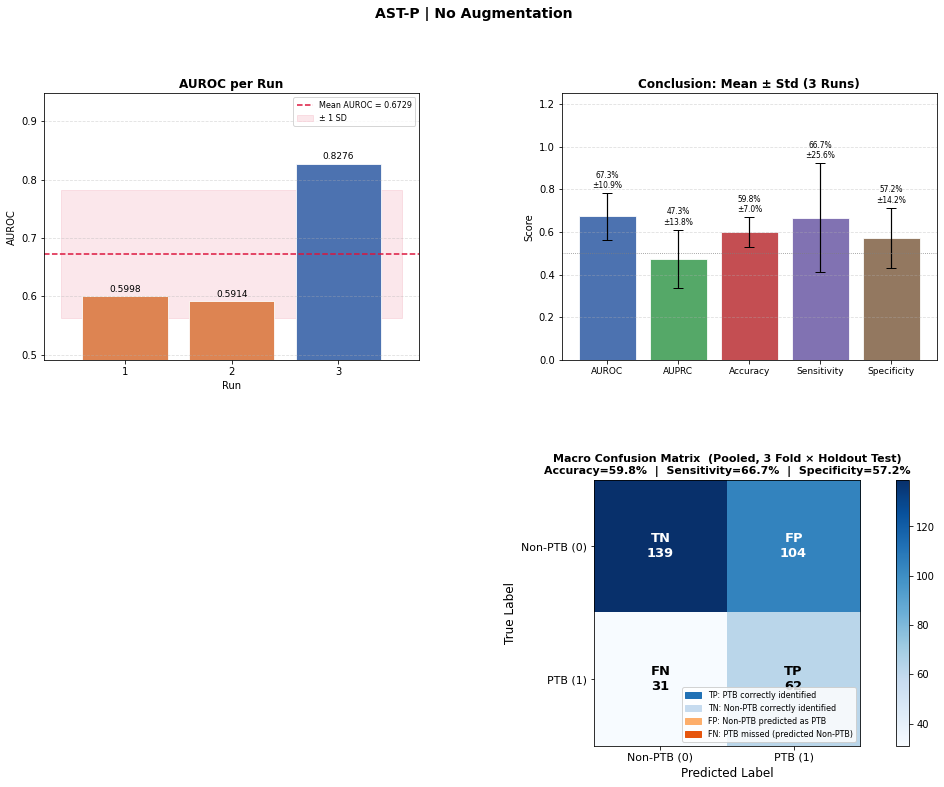

In [8]:
# =============================================================================
# STEP 4: AGGREGATE RESULTS — Conclusion Evaluation + Confusion Matrix
# =============================================================================
# ★ Output: exp/kfold_3runs_2dcnn/aggregate_results.json + plots/
# =============================================================================

import numpy as np
import json
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

assert len(all_run_metrics) == N_RUNS, \
    f"Expected {N_RUNS} run results, got {len(all_run_metrics)}. Run Step 3 first."

# --------------------------------------------------------------------------- #
# 4.1  แยก Metric Arrays
# --------------------------------------------------------------------------- #
aurocs        = np.array([m["auroc"]       for m in all_run_metrics])
auprcs        = np.array([m["auprc"]       for m in all_run_metrics])
accuracies    = np.array([m["accuracy"]    for m in all_run_metrics])
sensitivities = np.array([m["sensitivity"] for m in all_run_metrics])
specificities = np.array([m["specificity"] for m in all_run_metrics])
thresholds    = np.array([m["threshold"]   for m in all_run_metrics])
best_epochs   = np.array([m["best_epoch"]  for m in all_run_metrics])
val_maucs     = np.array([m["val_mauc"]    for m in all_run_metrics])

# Macro Confusion Matrix (pooled)
macro_TP = sum(m["TP"] for m in all_run_metrics)
macro_TN = sum(m["TN"] for m in all_run_metrics)
macro_FP = sum(m["FP"] for m in all_run_metrics)
macro_FN = sum(m["FN"] for m in all_run_metrics)
total_N  = macro_TP + macro_TN + macro_FP + macro_FN

macro_acc  = (macro_TP + macro_TN) / total_N if total_N > 0 else 0
macro_sens = macro_TP / (macro_TP + macro_FN) if (macro_TP + macro_FN) > 0 else 0
macro_spec = macro_TN / (macro_TN + macro_FP) if (macro_TN + macro_FP) > 0 else 0

# --------------------------------------------------------------------------- #
# 4.2  บันทึก Aggregate JSON
# --------------------------------------------------------------------------- #
aggregate = {
    "model":       "AST-P",
    "task":        "TB Screening (PTB vs Non-PTB)",
    "cv_strategy": f"{N_RUNS}-Run Independent Random Split (2DCNN-Style) on 80% Pool + Shared Holdout Test (20%)",
    "n_runs":      N_RUNS,
    "val_size_per_run": RUN_VAL_SIZE,
    "seeds":       [RANDOM_STATE + i for i in range(1, N_RUNS + 1)],
    "holdout_test_files": all_run_metrics[0]["n_test"],
    "per_run":     [{k: v for k, v in m.items()
                     if k not in ("y_true", "y_pred", "prob_ptb")}
                    for m in all_run_metrics],
    "conclusion": {
        "AUROC":       {"mean": float(aurocs.mean()),       "std": float(aurocs.std())},
        "AUPRC":       {"mean": float(auprcs.mean()),       "std": float(auprcs.std())},
        "Accuracy":    {"mean": float(accuracies.mean()),   "std": float(accuracies.std())},
        "Sensitivity": {"mean": float(sensitivities.mean()),"std": float(sensitivities.std())},
        "Specificity": {"mean": float(specificities.mean()),"std": float(specificities.std())},
        "Threshold":   {"mean": float(thresholds.mean()),   "std": float(thresholds.std())},
    },
    "macro_confusion_matrix": {
        "TP": macro_TP, "TN": macro_TN, "FP": macro_FP, "FN": macro_FN,
        "Accuracy":    float(macro_acc),
        "Sensitivity": float(macro_sens),
        "Specificity": float(macro_spec),
    }
}
agg_output_path = os.path.join(EXP_ROOT, "aggregate_results.json")
os.makedirs(os.path.dirname(agg_output_path), exist_ok=True)
with open(agg_output_path, "w") as f:
    json.dump(aggregate, f, indent=4)

# --------------------------------------------------------------------------- #
# 4.3  Console Output
# --------------------------------------------------------------------------- #
SEP_THICK = "═" * 65
SEP_THIN  = "─" * 65

print(SEP_THICK)
print("  AST-P - No Augmented")
print("  Task: Tuberculosis Screening  (PTB vs Non-PTB)")
print("  Test: Shared Holdout Set (20% of all patients)")
print(SEP_THICK)

print(f"\n  {'Fold':<6} {'Seed':>5} {'AUROC':>7} {'AUPRC':>7} "
      f"{'Sens%':>7} {'Spec%':>7} {'Acc%':>7} {'Thresh':>8} {'BestEp':>7}")
print(f"  {'─'*6} {'─'*5} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*8} {'─'*7}")
for m in all_run_metrics:
    print(f"  {m['run']:<6} "
          f"{m['seed']:>5} "
          f"{m['auroc']:>7.4f} "
          f"{m['auprc']:>7.4f} "
          f"{m['sensitivity']*100:>7.2f} "
          f"{m['specificity']*100:>7.2f} "
          f"{m['accuracy']*100:>7.2f} "
          f"{m['threshold']:>8.4f} "
          f"{m['best_epoch']:>7d}")
print(f"  {'─'*6} {'─'*5} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*8} {'─'*7}")
print(f"  {'Mean':<6} {'':>5} {aurocs.mean():>7.4f} {auprcs.mean():>7.4f} "
      f"{sensitivities.mean()*100:>7.2f} {specificities.mean()*100:>7.2f} "
      f"{accuracies.mean()*100:>7.2f} {thresholds.mean():>8.4f}")
print(f"  {'Std':<6} {'':>5} {aurocs.std():>7.4f} {auprcs.std():>7.4f} "
      f"{sensitivities.std()*100:>7.2f} {specificities.std()*100:>7.2f} "
      f"{accuracies.std()*100:>7.2f} {thresholds.std():>8.4f}")

print(f"\n{SEP_THICK}")
print("  CONCLUSION EVALUATION  (Mean ± Std,  N=3 Fold)")
print(SEP_THICK)
metrics_report = [
    ("AUROC",        aurocs,        "%"),
    ("AUPRC",        auprcs,        "%"),
    ("Accuracy",     accuracies,    "%"),
    ("Sensitivity",  sensitivities, "%"),
    ("Specificity",  specificities, "%"),
    ("Threshold",    thresholds,    ""),
]
for name, arr, unit in metrics_report:
    scale = 100 if unit == "%" else 1
    print(f"  {name:<16} : {arr.mean()*scale:.2f}{unit}  ±  {arr.std()*scale:.2f}{unit}")

print(f"\n{SEP_THICK}")
print("  MACRO CONFUSION MATRIX  (Pooled across all Fold × Holdout Test)")
print(SEP_THICK)
print(f"  {'':22}  Predicted")
print(f"  {'Actual':22}  Non-PTB   PTB")
print(f"  {'─'*40}")
print(f"  {'Non-PTB (Label=0)':22}  TN={macro_TN:4d}   FP={macro_FP:4d}")
print(f"  {'PTB     (Label=1)':22}  FN={macro_FN:4d}   TP={macro_TP:4d}")
print(f"  {'─'*40}")
print(f"  Macro Accuracy    : {macro_acc*100:.2f}%")
print(f"  Macro Sensitivity : {macro_sens*100:.2f}%")
print(f"  Macro Specificity : {macro_spec*100:.2f}%")

print(f"\n{SEP_THICK}")
print("  CLINICAL INTERPRETATION")
print(SEP_THIN)
sens_mean = sensitivities.mean()
spec_mean = specificities.mean()
sens_rate = ("Excellent (≥85%) — suitable for screening" if sens_mean >= 0.85
             else "Good (≥75%) — acceptable for assisted screening" if sens_mean >= 0.75
             else "Needs improvement (<75%)")
spec_rate = ("Excellent (≥80%) — low false alarm rate" if spec_mean >= 0.80
             else "Acceptable (≥65%)" if spec_mean >= 0.65
             else "Low (<65%) — high false alarm rate")
print(f"  Sensitivity  → {sens_rate}")
print(f"  Specificity  → {spec_rate}")
print(f"\n  Youden's J threshold (from VAL) was applied per fold.")
print(f"  All folds were evaluated on the same Holdout Test Set (20%).")
print(SEP_THICK)

# --------------------------------------------------------------------------- #
# 4.4  Visualizations
# --------------------------------------------------------------------------- #
run_labels = [m["run"]  for m in all_run_metrics]
colors_bar = ["#4C72B0" if a >= aurocs.mean() else "#DD8452" for a in aurocs]

fig = plt.figure(figsize=(16, 12))
fig.suptitle("AST-P | No Augmentation ",
             fontsize=14, fontweight="bold", y=0.98)
gs = GridSpec(2, 2, figure=fig, hspace=0.45, wspace=0.38)

# Plot A: Per-Run AUROC
ax_auc = fig.add_subplot(gs[0, 0])
bars = ax_auc.bar(run_labels, aurocs, color=colors_bar, edgecolor="white", linewidth=0.8)
ax_auc.axhline(aurocs.mean(), color="crimson", linewidth=1.5,
               linestyle="--", label=f"Mean AUROC = {aurocs.mean():.4f}")
ax_auc.fill_between([0.4, N_RUNS + 0.6],
                    aurocs.mean() - aurocs.std(),
                    aurocs.mean() + aurocs.std(),
                    color="crimson", alpha=0.10, label=f"± 1 SD")
for bar, val in zip(bars, aurocs):
    ax_auc.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                f"{val:.4f}", ha="center", va="bottom", fontsize=9)
ax_auc.set_title("AUROC per Run", fontweight="bold")
ax_auc.set_xlabel("Run")
ax_auc.set_ylabel("AUROC")
ax_auc.set_ylim(max(0, aurocs.min() - 0.1), min(1.05, aurocs.max() + 0.12))
ax_auc.set_xticks(run_labels)
ax_auc.legend(fontsize=8)
ax_auc.grid(axis="y", linestyle="--", alpha=0.4)

# Plot B: Conclusion Metrics
ax_met = fig.add_subplot(gs[0, 1])
metric_names = ["AUROC", "AUPRC", "Accuracy", "Sensitivity", "Specificity"]
means = [aurocs.mean(), auprcs.mean(), accuracies.mean(),
         sensitivities.mean(), specificities.mean()]
stds  = [aurocs.std(),  auprcs.std(),  accuracies.std(),
         sensitivities.std(),  specificities.std()]
x_pos = np.arange(len(metric_names))
color_met = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#937860"]
err_kw    = dict(ecolor="black", capsize=5, linewidth=1.2)
ax_met.bar(x_pos, means, yerr=stds, color=color_met,
           edgecolor="white", linewidth=0.8, error_kw=err_kw)
for i, (m_val, s_val) in enumerate(zip(means, stds)):
    ax_met.text(i, m_val + s_val + 0.015,
                f"{m_val*100:.1f}%\n±{s_val*100:.1f}%",
                ha="center", va="bottom", fontsize=7.5)
ax_met.set_title("Conclusion: Mean ± Std (3 Runs)", fontweight="bold")
ax_met.set_xticks(x_pos)
ax_met.set_xticklabels(metric_names, fontsize=9)
ax_met.set_ylabel("Score")
ax_met.set_ylim(0, 1.25)
ax_met.axhline(0.5, color="gray", linewidth=0.8, linestyle=":")
ax_met.grid(axis="y", linestyle="--", alpha=0.4)

# Plot C: Macro Confusion Matrix
ax_cm = fig.add_subplot(gs[1, :])
cm_matrix = np.array([[macro_TN, macro_FP],
                       [macro_FN, macro_TP]])
im = ax_cm.imshow(cm_matrix, interpolation="nearest", cmap="Blues")
plt.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)
tick_labels = ["Non-PTB (0)", "PTB (1)"]
ax_cm.set_xticks([0, 1]);  ax_cm.set_xticklabels(tick_labels, fontsize=11)
ax_cm.set_yticks([0, 1]);  ax_cm.set_yticklabels(tick_labels, fontsize=11)
ax_cm.set_xlabel("Predicted Label", fontsize=12)
ax_cm.set_ylabel("True Label", fontsize=12)
ax_cm.set_title(
    f"Macro Confusion Matrix  (Pooled, {N_RUNS} Fold × Holdout Test)\n"
    f"Accuracy={macro_acc*100:.1f}%  |  Sensitivity={macro_sens*100:.1f}%  |  Specificity={macro_spec*100:.1f}%",
    fontweight="bold", fontsize=11)

cell_text = [[f"TN\n{macro_TN}", f"FP\n{macro_FP}"],
             [f"FN\n{macro_FN}", f"TP\n{macro_TP}"]]
cm_norm   = cm_matrix / (cm_matrix.max() + 1e-9)
for i in range(2):
    for j in range(2):
        text_color = "white" if cm_norm[i, j] > 0.5 else "black"
        ax_cm.text(j, i, cell_text[i][j],
                   ha="center", va="center",
                   fontsize=13, fontweight="bold", color=text_color)

tp_patch = mpatches.Patch(color="#2171b5",  label="TP: PTB correctly identified")
tn_patch = mpatches.Patch(color="#c6dbef",  label="TN: Non-PTB correctly identified")
fp_patch = mpatches.Patch(color="#fdae6b",  label="FP: Non-PTB predicted as PTB")
fn_patch = mpatches.Patch(color="#e6550d",  label="FN: PTB missed (predicted Non-PTB)")
ax_cm.legend(handles=[tp_patch, tn_patch, fp_patch, fn_patch],
             loc="lower right", fontsize=8, framealpha=0.85)

plot_dir  = os.path.join(EXP_ROOT, "plots")
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, "aggregate_results.png")
plt.savefig(plot_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"\n[✓] Plot saved → {plot_path}")
print(f"[✓] Results JSON → {agg_output_path}")
print(f"[✓] Pipeline complete.")

[✓] Using all_run_metrics from memory.
  Run 1: AUROC = 0.5998  |  Threshold (Youden) = 0.9009  → FPR=0.136, TPR=0.323
  Run 2: AUROC = 0.5914  |  Threshold (Youden) = 0.9976  → FPR=0.296, TPR=0.484
  Run 3: AUROC = 0.8276  |  Threshold (Youden) = 0.0077  → FPR=0.185, TPR=0.774


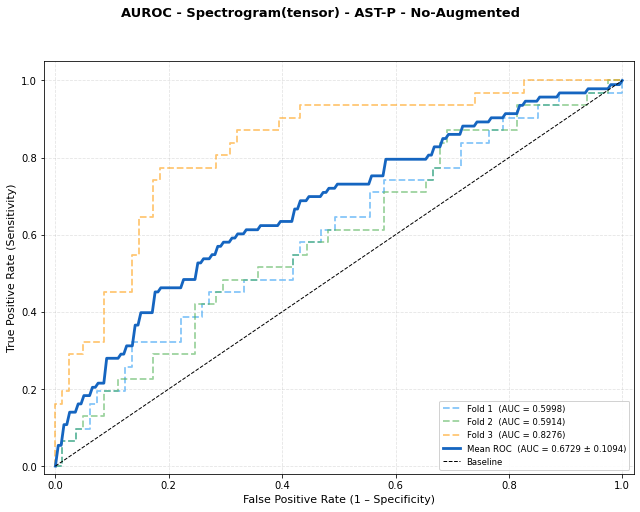


[✓] ROC plot saved → z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\plots\roc_per_run.png

═══════════════════════════════════════════════════════
  AUC SUMMARY
───────────────────────────────────────────────────────
  Run 1  :  AUC = 0.5998
  Run 2  :  AUC = 0.5914
  Run 3  :  AUC = 0.8276
───────────────────────────────────────────────────────
  Mean   :  AUC = 0.6729
  ± Std  :       ± 0.1094
═══════════════════════════════════════════════════════


In [11]:
# ============================================================
# test_tb_AST-P_3Runs_2DCNNSplit.ipynb
# Plot ROC / AUC Curve per Run + Mean ± SD
# ============================================================

import os
import json
import numpy as np
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ------------------------------------------------------------------ #
# CONFIG — adjust to match your notebook paths
# ------------------------------------------------------------------ #
BASE_DIR  = r"z:\AST-With-TB-Classify"
EXP_ROOT  = os.path.join(BASE_DIR, "exp", "kfold_3runs_2dcnn")
FOLD_ROOT = os.path.join(BASE_DIR, "json_folds_3runs")
N_RUNS    = 3

# ------------------------------------------------------------------ #
# LOAD per-run predictions
# Each run_X/test_metrics.json does NOT store y_true / prob_ptb,
# so we load the raw lists from all_run_metrics saved as extended json.
# Fallback: re-load from per-run extended json if available,
#           otherwise raise clear error.
# ------------------------------------------------------------------ #

def load_run_predictions(run_num: int):
    """
    Try to load y_true and prob_ptb from
    exp/kfold_3runs_2dcnn/run_X/test_predictions.json
    (extended file that includes raw arrays).
    Falls back to test_metrics.json if arrays exist there.
    """
    run_exp_dir = os.path.join(EXP_ROOT, f"run_{run_num}")

    # --- Option A: dedicated predictions file (recommended) ----------
    pred_path = os.path.join(run_exp_dir, "test_predictions.json")
    if os.path.exists(pred_path):
        with open(pred_path) as f:
            d = json.load(f)
        return (np.array(d["y_true"]),
                np.array(d["prob_ptb"]),
                d.get("threshold", 0.5),
                d.get("auroc", None))

    # --- Option B: test_metrics.json (may not have raw arrays) -------
    metrics_path = os.path.join(run_exp_dir, "test_metrics.json")
    if os.path.exists(metrics_path):
        with open(metrics_path) as f:
            d = json.load(f)
        if "y_true" in d and "prob_ptb" in d:
            return (np.array(d["y_true"]),
                    np.array(d["prob_ptb"]),
                    d.get("threshold", 0.5),
                    d.get("auroc", None))

    raise FileNotFoundError(
        f"[Run {run_num}] Cannot find prediction arrays.\n"
        f"  Expected: {pred_path}\n"
        f"  Or arrays in: {metrics_path}\n"
        f"  → Re-run Step 3 of the pipeline and save y_true/prob_ptb."
    )


# ------------------------------------------------------------------ #
# If `all_run_metrics` is already in memory (run from same kernel),
# use it directly — otherwise load from disk.
# ------------------------------------------------------------------ #
try:
    assert "all_run_metrics" in dir() or "all_run_metrics" in globals()
    _ = all_run_metrics[0]["y_true"]          # check raw arrays exist
    print("[✓] Using all_run_metrics from memory.")
    run_data = [
        (np.array(m["y_true"]),
         np.array(m["prob_ptb"]),
         m["threshold"],
         m["auroc"])
        for m in all_run_metrics
    ]
except Exception:
    print("[i] Loading predictions from disk …")
    run_data = [load_run_predictions(r) for r in range(1, N_RUNS + 1)]

# ------------------------------------------------------------------ #
# COMPUTE ROC per Run
# ------------------------------------------------------------------ #
mean_fpr   = np.linspace(0, 1, 200)
tpr_interp = []
run_fprs, run_tprs, run_aucs, run_thresholds = [], [], [], []

for idx, (y_true, prob_ptb, opt_thresh, stored_auroc) in enumerate(run_data):
    fpr, tpr, thresholds_roc = roc_curve(y_true, prob_ptb, pos_label=1)
    auroc_val = auc(fpr, tpr)

    tpr_i = np.interp(mean_fpr, fpr, tpr)
    tpr_i[0] = 0.0
    tpr_interp.append(tpr_i)

    youden_j  = tpr - fpr
    best_idx  = np.argmax(youden_j)
    thresh_fpr = fpr[best_idx]
    thresh_tpr = tpr[best_idx]

    run_fprs.append(fpr)
    run_tprs.append(tpr)
    run_aucs.append(auroc_val)
    run_thresholds.append((thresh_fpr, thresh_tpr, opt_thresh))

    print(f"  Run {idx+1}: AUROC = {auroc_val:.4f}  |  "
          f"Threshold (Youden) = {opt_thresh:.4f}  "
          f"→ FPR={thresh_fpr:.3f}, TPR={thresh_tpr:.3f}")

tpr_interp = np.array(tpr_interp)
mean_tpr   = tpr_interp.mean(axis=0)
mean_tpr[-1] = 1.0
std_tpr    = tpr_interp.std(axis=0)
mean_auc   = np.mean(run_aucs)
std_auc    = np.std(run_aucs)

# ------------------------------------------------------------------ #
# PLOT — Single Combined Graph
# ------------------------------------------------------------------ #
RUN_COLORS = ["#2196F3", "#4CAF50", "#FF9800"]   # blue, green, orange

fig, ax = plt.subplots(figsize=(9, 7))
fig.suptitle(
    "AUROC - Spectrogram(tensor) - AST-P - No-Augmented\n",
    fontsize=13, fontweight="bold", y=1.01
)

# ── Individual ROC curves (faded) + Youden markers ─────────────── #
for i, (fpr_i, tpr_i, auroc_i) in enumerate(zip(run_fprs, run_tprs, run_aucs)):
    ax.plot(fpr_i, tpr_i,
            color=RUN_COLORS[i],
            linewidth=1.8,
            alpha=0.55,
            linestyle="--",
            label=f"Fold {i+1}  (AUC = {auroc_i:.4f})")



# ── Mean ROC curve ─────────────────────────────────────────────── #
ax.plot(mean_fpr, mean_tpr,
        color="#1565C0",
        linewidth=2.8,
        label=f"Mean ROC  (AUC = {mean_auc:.4f} ± {std_auc:.4f})")

# ── Random baseline ────────────────────────────────────────────── #
ax.plot([0, 1], [0, 1], "k--", linewidth=1, label="Baseline")

# ── Axes formatting ────────────────────────────────────────────── #
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.05])
ax.set_xlabel("False Positive Rate (1 – Specificity)", fontsize=11)
ax.set_ylabel("True Positive Rate (Sensitivity)", fontsize=11)
ax.legend(loc="lower right", fontsize=8.5, framealpha=0.88)
ax.grid(True, linestyle="--", alpha=0.35)

plt.tight_layout()

# ------------------------------------------------------------------ #
# SAVE
# ------------------------------------------------------------------ #
plot_dir  = os.path.join(EXP_ROOT, "plots")
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, "roc_per_run.png")
plt.savefig(plot_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()

print(f"\n[✓] ROC plot saved → {plot_path}")
print(f"\n{'═'*55}")
print(f"  AUC SUMMARY")
print(f"{'─'*55}")
for i, a in enumerate(run_aucs):
    print(f"  Run {i+1}  :  AUC = {a:.4f}")
print(f"{'─'*55}")
print(f"  Mean   :  AUC = {mean_auc:.4f}")
print(f"  ± Std  :       ± {std_auc:.4f}")
print(f"{'═'*55}")